# **Sea World Simulation Project**

# Implementation Details


# 🌊 System Architecture and Simulation Model - Water Park

In this section, we detail the hierarchical structure of the code, the entities participating in the simulation, and the logic driving the events. The model is based on **Discrete Event Simulation**, simulating park activity from the moment the gates open until the analysis of statistical metrics at the end of the day.

---

### 👥 Visitor Classes
The system manages visitors in logical layers to allow for tracking satisfaction, budget management, and group decision-making:

* **Visitor:** The base class representing an individual visitor (parent, child, teenager, or solo visitor). It holds variables such as enjoyment level (Rating), the amount paid, and "Express" status.
* **FamilyGroup:** A group consisting of two parents and children. The group acts as a single unit until a potential split point.
* **SplitFamilyGroup:** Represents a family that has split into sub-groups (subject to supervision constraints) to maximize time utilization in the park.
* **TeenGroup:** A group of teenagers characterized by a preference for high-adrenaline attractions.

---

### 🎢 Infrastructure Classes
* **Facility:** The parent class for all park attractions (slides, pools, snorkeling tours). It manages resources, capacity, age restrictions, and service times.
* **FoodStand:** The parent class for all food stalls in the park.
* **QueueServer:** A class modeling a queue. Each facility maintains two separate queues (Regular and Express) which are instances of this class. It is also responsible for collecting real-time statistics (queue length and waiting times).
* **Simulation:** The class that manages the event timeline and stores daily metrics. It contains the `proceed_to_next_activity` method - the core logic that simulates visitor decision-making, determining the next attraction for each group or individual based on the time, personal preferences, and visited facilities list.



---

### 📅 Key Events
The simulation is driven by a sequence of events that trigger one another along the timeline:

1.  **ParkArrivalEvent:** A recursive event responsible for visitor entry. Upon arrival, the system samples the arrival time of the next visitor of the same type and schedules a new arrival event.
2.  **ArrivalToFacilityEvent:** Manages arrival at a facility—routing the visitor to immediate service or to the appropriate queue (Regular/Express) based on their wristband type.
3.  **EndServiceEvent:** Marks the end of facility use, updates visitor metrics, and triggers the logic to admit the next person in line.
4.  **Diving Instructor Break Events:**
    * **InstructorEndBreakEvent:** Ends an instructor's break (either a routine gap between tours or a lunch break). In our implementation, an instructor goes on lunch break if they finish a gap or a tour between 12:40 PM and 2:00 PM.
    * **InstructorStartLunchBreakEvent:** A "safety" event for edge cases where an instructor is idle (empty queue) and wouldn't otherwise be triggered to start a lunch break at 1:00 PM.
5.  **Food Stand Events:**
    * **ArrivalToFoodStandEvent:** Models arrival at the food court area.
    * **FinishedEatingEvent:** Models departure from the food court.
6.  **QueueAbandonmentEvent:** Removes a visitor from a queue if the waiting time exceeds their personal patience threshold.
7.  **EmptyQueueEvent:** Occurs at 6:50 PM (near closing); a park employee clears all queues in preparation for shutdown.
8.  **DepartureEvent:** A visitor leaves the park, and their final metrics (rating, total spending) are saved.
9.  **EndOfDayEvent:** Models the end of a simulation day, calculating daily totals and resetting parameters for the next day.

---

### 📝 Core Model Assumptions
To reflect reality accurately while maintaining model stability, we established the following assumptions:

1.  **Food Stands:** There are no queues at food stands. When a customer arrives, they order immediately (similar to a fast-food kiosk system). This assumption was approved by the course staff.
2.  **Instructor Lunch Breaks:** If an instructor finishes a task between 12:40 PM and 2:00 PM, they remain on break until 2:00 PM. Visitors are aware that no new tours start during this window and will not choose snorkeling when deciding on a new activity. If snorkeling is their only remaining activity, they will leave the park.
    * *Note:* We chose this over "pre-sampling" tour durations because, in reality, an instructor cannot know exactly when a tour will end before it happens. Our implementation favors simulation reliability over retrospective sampling.
3.  **Family Splitting:** If a family cannot mathematically split into 3 sub-groups (based on the ratio of supervisors to children requiring supervision), they will not split at all.
4.  **Departure and Closing Assumptions:**
    * Visitors who abandon the queue for their final remaining attraction will leave the park.
    * Visitors whose only remaining task is snorkeling between 12:40 PM and 2:00 PM will leave rather than wait for the instructors to return.
    * Visitors finishing an activity at 6:45 PM or later will leave the park rather than starting a new activity.
    * At 6:50 PM, an employee clears all facility queues.
    * At 7:00 PM, all pools (Wave and Mini) are completely cleared, regardless of the visitors' sampled end times.
    * Instructors will end the final snorkeling tour by 7:00 PM at the latest, regardless of the sampled duration.
5.  **Flexible Closing Time:** While we aim for a 7:00 PM close, we do not force-stop active riders on slides or tubes (as that would be unrealistic). Consequently, if a visitor began a ride before the 6:50 PM queue clearance, they may finish slightly after 7:00 PM, technically closing the park a few minutes late.
    * *Note:* We believe this "natural finish" reflects reality better than canceling rides mid-way based on a retrospective check of end-times.


In [4]:
#imports block
import math
import heapq
import pandas as pd
import numpy as np
import random
from typing import List, Dict, Union, Tuple
from sympy import symbols, Eq, solve
from scipy import stats
from scipy.optimize import root_scalar
from IPython.display import display, HTML
from scipy.stats import probplot, norm, t
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import truncnorm
from datetime import timedelta, datetime, time
from contextlib import closing
import heapq
from enum import Enum
from datetime import timedelta
import uuid
import os


# Statistics Tests for big and small tubing slide distribution

We'll use the data provided in the excel file to find the distribution for both big and small tubing slides.


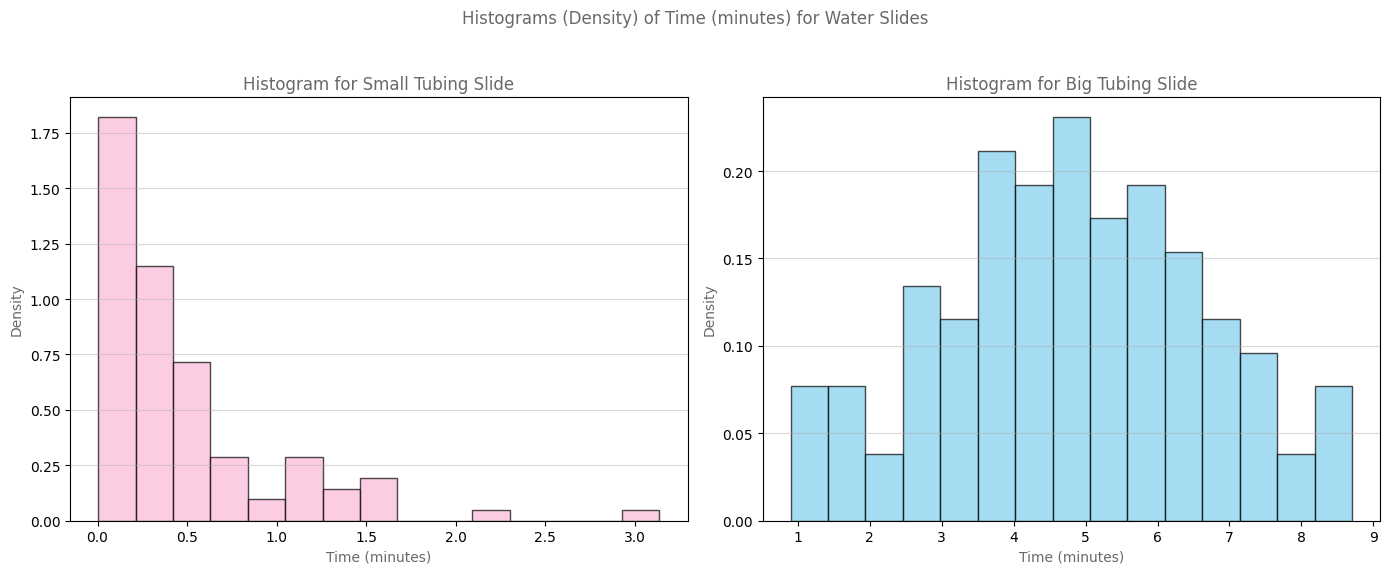

In [5]:
excel_file_name = 'Samples for course project.xlsx'

# Load data from specific worksheets using pd.read_excel, as you requested
df_big = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים גדולה')
df_small = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים קטנה ')

# --- Prepare data and titles for the fixed plot ---
data_big = df_big['time_minutes'].dropna()
data_small = df_small['time_minutes'].dropna()

title_big_en = 'Big Tubing Slide'
title_small_en = 'Small Tubing Slide'

# Define colors for aesthetic consistency
unified_blue = "#80CEED" # Used for Big Slide
unified_pink = "#FCB8D6" # Used for Small Slide

# Plotting the histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle('Histograms (Density) of Time (minutes) for Water Slides', color='dimgray')

# --- Histogram for Small Slide Data (LEFT SIDE - axs[0]) ---
axs[0].hist(data_small, bins=15, edgecolor='black', alpha=0.7, label='Histogram', color=unified_pink, density=True)
axs[0].set_title(f"Histogram for {title_small_en}", color='dimgray')
axs[0].set_xlabel("Time (minutes)", color='dimgray')
axs[0].set_ylabel('Density', color='dimgray')
axs[0].grid(axis='y', alpha=0.5)

# --- Histogram for Big Slide Data (RIGHT SIDE - axs[1]) ---
axs[1].hist(data_big, bins=15, edgecolor='black', alpha=0.7, label='Histogram', color=unified_blue, density=True)
axs[1].set_title(f"Histogram for {title_big_en}", color='dimgray')
axs[1].set_xlabel("Time (minutes)", color='dimgray')
axs[1].set_ylabel('Density', color='dimgray')
axs[1].grid(axis='y', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Distribution Fitting Analysis for Tube Slides

Based on the initial graphical analysis of the data provided in the Excel file, the following distributions were hypothesized for the sliding times:

---

### 1. Small Tube Slide

#### **Hypothesized Distribution:** Exponential Distribution

#### **Maximum Likelihood Estimation (MLE) for $\lambda$**

The parameter of the exponential distribution is the rate ($\lambda$).

**1. Probability Density Function (PDF):**



$$
f(x; \lambda) = \lambda e^{-\lambda x}, \quad x \geq 0
$$

**2. Log-Likelihood Function ($\ell(\lambda)$) for a sample of size $n$:**

$$
\ell(\lambda) = \ln L(\lambda) = n \ln(\lambda) - \lambda \sum_{i=1}^n x_i
$$

**3. Finding the MLE ($\lambda_{MLE}$):**
We set the derivative of $\ell(\lambda)$ with respect to $\lambda$ to zero:

$$
\frac{d\ell(\lambda)}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0
$$

**MLE Formula:**

$$
\lambda_{MLE} = \frac{n}{\sum_{i=1}^n x_i} = \frac{1}{\bar{x}}
$$

---

### 2. Big Tube Slide

#### **Hypothesized Distribution:** Normal Distribution

#### **Maximum Likelihood Estimation (MLE) for $\mu$ and $\sigma^2$**

The parameters of the normal distribution are the mean ($\mu$) and the variance ($\sigma^2$).

**1. Probability Density Function (PDF):**



$$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

**2. Log-Likelihood Function ($\ell(\mu, \sigma^2)$) for a sample of size $n$:**

$$
\ell(\mu, \sigma^2) = -\frac{n}{2} \ln(2\pi) - \frac{n}{2} \ln(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu)^2
$$

**3. Finding the MLE for the mean ($\mu_{MLE}$):**
By setting the partial derivative of $\ell$ with respect to $\mu$ to zero:


$$
\mu_{MLE} = \bar{x}
$$

**4. Finding the MLE for the variance ($\sigma^2_{MLE}$):**
By setting the partial derivative of $\ell$ with respect to $\sigma^2$ to zero and substituting $\mu_{MLE}$:

$$
\sigma^2_{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \mu_{MLE})^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2
$$

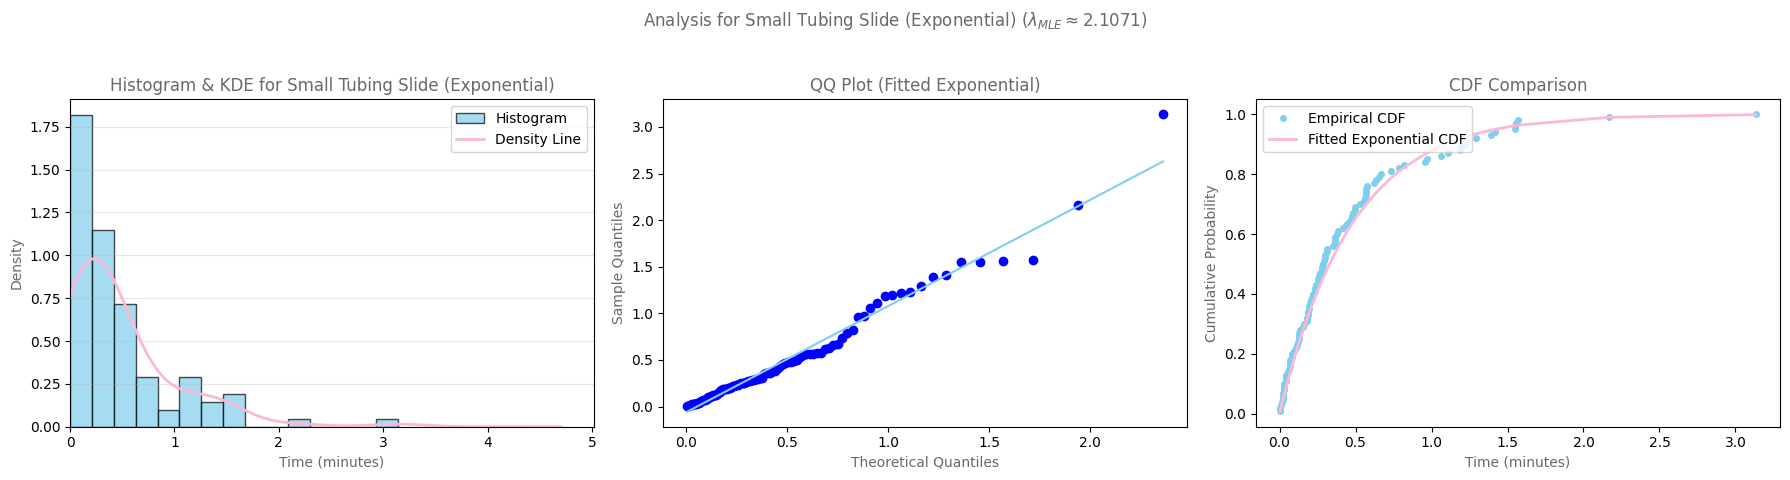

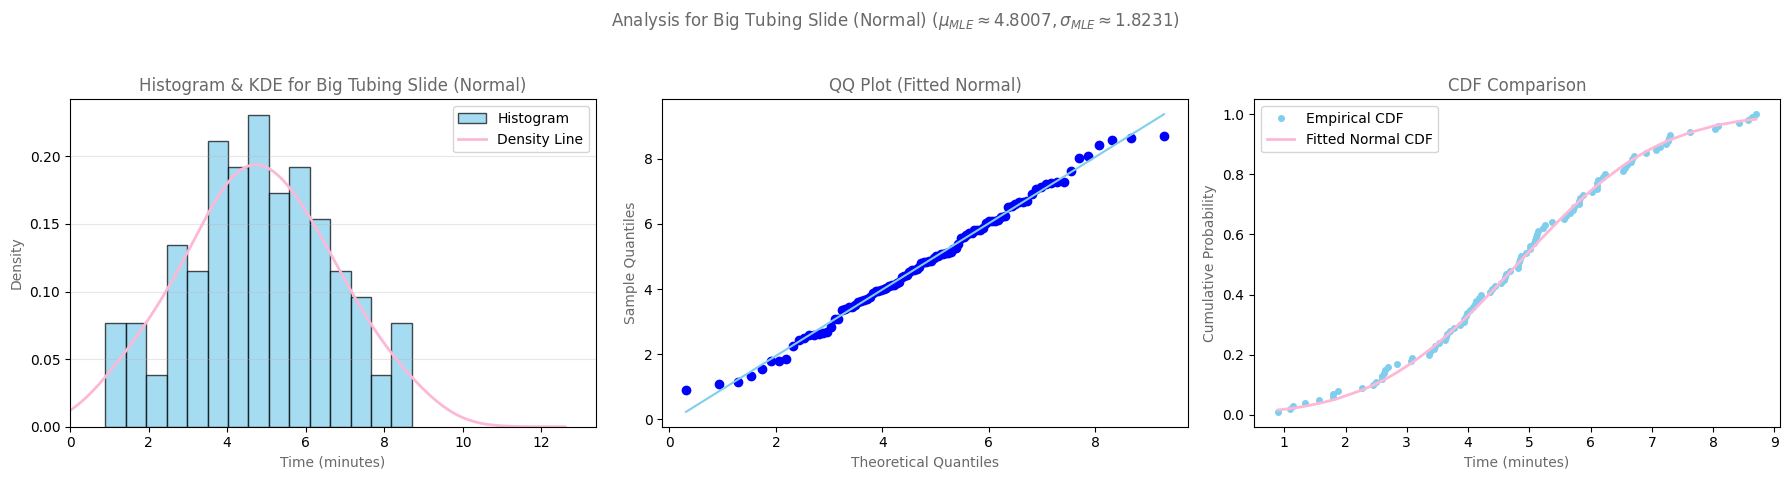

In [6]:
# --- 1. Data Loading ---
excel_file_name = 'Samples for course project.xlsx'
# Load data from specific worksheets
df_big = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים גדולה')
df_small = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים קטנה ')

data_big = df_big['time_minutes'].dropna()
data_small = df_small['time_minutes'].dropna()

# --- 2. Define Analysis Functions ---

def histogram_and_density_line(data, column_name, ax, color_hist, color_kde, bins_count=15):
    """Plots histogram (density=True) and kernel density estimate (KDE)."""
    ax.hist(data, bins=bins_count, edgecolor='black', alpha=0.7, label='Histogram', color=color_hist, density=True)
    pd.Series(data).plot(kind='kde', color=color_kde, label='Density Line', bw_method=0.5, ax=ax, linewidth=2)
    ax.set_title(f"Histogram & KDE for {column_name}", color='dimgray')
    ax.set_xlabel(f"Time (minutes)", color='dimgray')
    ax.set_ylabel('Density', color='dimgray')
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

def MLE_for_lambda(data):
    """Calculates the MLE for lambda (Exponential distribution)."""
    def neg_log_likelihood(lambda_, data):
        lambda_val = lambda_[0] if isinstance(lambda_, np.ndarray) else lambda_
        positive_data = data[data > 0]
        n = len(positive_data)
        return -np.sum(n * np.log(lambda_val) - lambda_val * np.sum(positive_data))

    lambda_mle = 1 / np.mean(data)
    result = minimize(neg_log_likelihood, [lambda_mle], args=(data,), bounds=[(0.0001, None)])
    return result.x[0]

def Exponential_CDF_plot(data, lambda_mle, ax, color_points, color_line):
    """Compares Empirical CDF to the Fitted Exponential CDF."""
    sorted_data = np.sort(data)
    cdf_fitted = 1 - np.exp(-lambda_mle * sorted_data)
    empirical_cdf = np.arange(1, len(data)+1)/len(data)

    ax.plot(sorted_data, empirical_cdf, marker='o', linestyle='', markersize=4, label='Empirical CDF', color=color_points)
    ax.plot(sorted_data, cdf_fitted, '-', label='Fitted Exponential CDF', color=color_line, linewidth=2)
    ax.set_title('CDF Comparison', color='dimgray')
    ax.set_xlabel('Time (minutes)', color='dimgray')
    ax.set_ylabel('Cumulative Probability', color='dimgray')
    ax.legend(loc='upper left')

def Normal_CDF_plot(data, mu_mle, sigma_mle, ax, color_points, color_line):
    """Compares Empirical CDF to the Fitted Normal CDF."""
    sorted_data = np.sort(data)
    cdf_fitted = norm.cdf(sorted_data, loc=mu_mle, scale=sigma_mle)
    empirical_cdf = np.arange(1, len(data)+1)/len(data)

    ax.plot(sorted_data, empirical_cdf, marker='o', linestyle='', markersize=4, label='Empirical CDF', color=color_points)
    ax.plot(sorted_data, cdf_fitted, '-', label='Fitted Normal CDF', color=color_line, linewidth=2)
    ax.set_title('CDF Comparison', color='dimgray')
    ax.set_xlabel('Time (minutes)', color='dimgray')
    ax.set_ylabel('Cumulative Probability', color='dimgray')
    ax.legend(loc='upper left')

# --- 3. Parameter Calculation ---
lambda_mle_small = MLE_for_lambda(data_small)
mu_mle_big = np.mean(data_big)
sigma_mle_big = np.std(data_big)

# --- 4. Analysis Execution ---
title_big_en = 'Big Tubing Slide (Normal)'
title_small_en = 'Small Tubing Slide (Exponential)'
unified_blue = "#80CEED"
unified_pink = "#FCB8D6"

# 4a. Small Tubing Slide Analysis (Exponential)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle(rf'Analysis for {title_small_en} ($\lambda_{{MLE}} \approx {lambda_mle_small:.4f}$)', color='dimgray')

histogram_and_density_line(data_small, title_small_en, axs[0], unified_blue, unified_pink)
probplot(data_small, dist="expon", sparams=(0, 1/lambda_mle_small), plot=axs[1])
axs[1].get_lines()[1].set_color(unified_blue)
axs[1].set_title('QQ Plot (Fitted Exponential)', color='dimgray')
axs[1].set_xlabel('Theoretical Quantiles', color='dimgray')
axs[1].set_ylabel('Sample Quantiles', color='dimgray')
Exponential_CDF_plot(data_small, lambda_mle_small, axs[2], unified_blue, unified_pink)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4b. Big Tubing Slide Analysis (Normal)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle(rf'Analysis for {title_big_en} ($\mu_{{MLE}} \approx {mu_mle_big:.4f}, \sigma_{{MLE}} \approx {sigma_mle_big:.4f}$)', color='dimgray')

histogram_and_density_line(data_big, title_big_en, axs[0], unified_blue, unified_pink)
probplot(data_big, dist="norm", sparams=(mu_mle_big, sigma_mle_big), plot=axs[1])
axs[1].get_lines()[1].set_color(unified_blue)
axs[1].set_title('QQ Plot (Fitted Normal)', color='dimgray')
axs[1].set_xlabel('Theoretical Quantiles', color='dimgray')
axs[1].set_ylabel('Sample Quantiles', color='dimgray')
Normal_CDF_plot(data_big, mu_mle_big, sigma_mle_big, axs[2], unified_blue, unified_pink)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Distribution Analysis for Water Slide Sliding Times

---

### **Histogram (Comparison with Theoretical Density - KDE):**

* **Small Tube Slide (Exponential Distribution):**
  The histogram displays a classic asymmetrical pattern with a sharp decline. The Kernel Density Estimation (KDE) curve overlaps significantly with the histogram bars, indicating a strong visual fit between the actual data and the exponential model.



* **Big Tube Slide (Normal Distribution):**
  The histogram shows a symmetrical shape concentrated around the mean. The KDE curve overlaps almost perfectly with the height of the histogram bars, demonstrating an excellent visual fit of the data to the normal model.



---

### **QQ Plot (Quantile-Quantile Plot):**

* **Small Tube Slide (Exponential Distribution):**
  The observations in the QQ Plot for the small slide generally align with the theoretical line of the exponential distribution, reinforcing the conclusion of an exponential fit.

* **Big Tube Slide (Normal Distribution):**
  The observations in the QQ Plot for the big slide show an almost perfect match with the diagonal theoretical line, indicating high compatibility with the normal model.



---

### **Summary:**

The analysis using graphical and statistical tools confirms the following assumptions:
* Sliding time for the **Small Tube Slide** follows an **Exponential Distribution**.
* Sliding time for the **Big Tube Slide** follows a **Normal Distribution**.

---

# Maximum Likelihood Estimation (MLE)

### **Exponential Distribution (Small Tube Slide):**

The Probability Density Function (PDF) is defined as:

$$
f(x; \lambda) =
\begin{cases}
\lambda e^{-\lambda x}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$

Where $\lambda$ is the rate parameter. The Maximum Likelihood Estimate (MLE) for $\lambda$ is the reciprocal of the sample mean ($\bar{x}$):

$$
\hat{\lambda}_{MLE} = \frac{1}{\bar{x}} = 2.1071
$$

### **Normal Distribution (Big Tube Slide):**

The Probability Density Function (PDF) is defined by two parameters: the mean ($\mu$) and the standard deviation ($\sigma$):

$$
f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}
$$

The Maximum Likelihood Estimates (MLE) for these parameters are the sample mean and the sample standard deviation:

**For the Mean ($\mu$):**
$$
\hat{\mu}_{MLE} = \bar{x} = 4.8007
$$

**For the Standard Deviation ($\sigma$):**
$$
\hat{\sigma}_{MLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2} = 1.8231
$$

In [7]:

# --- 0. Data Loading and Parameter Calculation ---

excel_file_name = 'Samples for course project.xlsx'
# Load data from specific worksheets
try:
    df_big = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים גדולה')
    df_small = pd.read_excel(excel_file_name, sheet_name='מגלשת אבובים קטנה ')
except FileNotFoundError:
    print(f"Error: File '{excel_file_name}' not found. Please check the file name/path.")
    exit()
except ValueError:
    print("Error: One or both sheet names were not found. Please verify the exact sheet names.")
    exit()

# Extract data series
data_big = df_big['time_minutes'].dropna().values
data_small = df_small['time_minutes'].dropna().values

# Function to calculate Exponential MLE (needed for Small Slide)
def MLE_for_lambda(data):
    def neg_log_likelihood(lambda_, data):
        lambda_val = lambda_[0] if isinstance(lambda_, np.ndarray) else lambda_
        positive_data = data[data > 0]
        n = len(positive_data)
        return -np.sum(n * np.log(lambda_val) - lambda_val * np.sum(positive_data))
    lambda_mle = 1 / np.mean(data)
    result = minimize(neg_log_likelihood, [lambda_mle], args=(data,), bounds=[(0.0001, None)])
    return result.x[0]

# Calculate MLEs/Parameters
lambda_mle_small = MLE_for_lambda(data_small)
mu_mle_big = np.mean(data_big)
sigma_mle_big = np.std(data_big)


# --- 1. KS Test Functions ---

def empirical_cdf(data):
    data_sorted = np.sort(data)
    n = len(data)
    return data_sorted, np.arange(1, n+1) / n

def ks_test(data, cdf, *params):
    n = len(data)
    data_sorted, empirical_cdf_values = empirical_cdf(data)
    theoretical_cdf_values = cdf(data_sorted, *params)
    d_statistic = np.max(np.abs(empirical_cdf_values - theoretical_cdf_values))
    # User-provided modification to D-statistic
    new_d_statistic = ((np.sqrt(n)+0.26+(0.25/np.sqrt(n))) * (d_statistic-0.2/n))
    return new_d_statistic

def exp_cdf(x, lambda_):
    return 1 - np.exp(-lambda_ * x)

def norm_cdf(x, mu, sigma):
    return norm.cdf(x, loc=mu, scale=sigma)

def d_critical(alpha):
    if 1-alpha == 0.95:
        return 1.094
    # ... other values ...
    return np.nan

def hypothesis_test(critical_value, d_statistic):
    # This function ensures the exact required output format
    d_stat_f = f"{d_statistic:.4f}"
    crit_val_f = f"{critical_value:.4f}"

    if d_statistic > critical_value:
        print(f"{d_stat_f} > {crit_val_f} therefore, Reject the null hypothesis")
    else:
        print(f"{d_stat_f} < {crit_val_f} therefore, Fail to reject the null hypothesis")


# --- 2. KS Test Execution (EXACT Output Formatting) ---
alpha = 0.05
critical_value = d_critical(alpha)

# a) Small Tubing Slide (Exponential)
display(HTML("<h2 style='text-align: letf ; color: orange;'>Small Tubing Slide KS test </h2>"))
d_statistic_small = ks_test(data_small, exp_cdf, lambda_mle_small)
print("D Statistic:", d_statistic_small) # Prints full float
print("Critical Value:", critical_value)
hypothesis_test(critical_value, d_statistic_small)

# b) Big Tubing Slide (Normal)
display(HTML("<h2 style='text-align: letf ; color: orange;'>Big Tubing Slide KS test </h2>"))
d_statistic_big = ks_test(data_big, norm_cdf, mu_mle_big, sigma_mle_big)
print("D Statistic:", d_statistic_big) # Prints full float
print("Critical Value:", critical_value)
hypothesis_test(critical_value, d_statistic_big)

D Statistic: 0.6834933009124003
Critical Value: 1.094
0.6835 < 1.0940 therefore, Fail to reject the null hypothesis


D Statistic: 0.35948916264293596
Critical Value: 1.094
0.3595 < 1.0940 therefore, Fail to reject the null hypothesis


# Distribution Validation using Kolmogorov-Smirnov (KS) Test

Based on the results of the KS test, the fit of the sliding times was tested against the corresponding theoretical distributions (Exponential for the Small Slide, Normal for the Big Slide).

---

### **Results for the Small Tube Slide (Exponential Distribution)**:

- **D-statistic:**
$\displaystyle D_{st} = 0.6835$

- **Critical Value at 5% significance level:**
$\displaystyle D_{\text{critical}} = 1.0940$



Since $D_{st} < D_{\text{critical}}$ ($0.6835 < 1.0940$), **there is insufficient evidence to reject the null hypothesis**. Therefore, the data fits the exponential distribution well with the calculated parameter:
$\displaystyle \lambda = 2.1071$

---

### **Results for the Big Tube Slide (Normal Distribution)**:

- **D-statistic:**
$\displaystyle D_{st} = 0.3595$

- **Critical Value at 5% significance level:**
$\displaystyle D_{\text{critical}} = 1.0940$



Similarly, since $D_{st} < D_{\text{critical}}$ ($0.3595 < 1.0940$), **we do not reject the null hypothesis**. This indicates a high level of fit to the normal distribution with the calculated parameters:
$\displaystyle \mu = 4.8007, \sigma = 1.8231$

---

### **Conclusion:**

In accordance with the KS test findings and the graphical analysis:

- **Small Tube Slide time** follows an exponential distribution with parameter:
$\displaystyle \lambda = 2.1071$

- **Big Tube Slide time** follows a normal distribution with parameters:
$\displaystyle \mu = 4.8007, \sigma = 1.8231$

# Sample Algorithms

<center>

$$
\begin{aligned}
&\mathbf{\Large \text{Calculating wave pool stay duration using Acceptance-Rejection method}} \\
\end{aligned}
$$

$$
f_{\text{wave\_pool}}(x) =
\begin{cases}
\frac{x}{2700} & \text{for } 0 \le x < 30, \\
\frac{60-x}{2700} + \frac{1}{30} & \text{for } 30 \le x < 50, \\
\frac{60-x}{2700} & \text{for } 50 \le x \le 60, \\
0 & \text{else}
\end{cases}
$$

**Find the maximum of $f(x)$:**
$$
\begin{aligned}
&\text{The function is defined over the interval } [0, 60]. \\
&\text{To find the global maximum, we evaluate the piecewise function at the boundaries.} \\
&\text{At } x=30 \text{ for the second piece: } f(30) = \frac{60-30}{2700} + \frac{1}{30} = \frac{30}{2700} + \frac{90}{2700} = \frac{120}{2700} = \frac{4}{90} \approx 0.0444. \\
&\text{Thus, the maximum value is } M = \frac{4}{90}.
\end{aligned}
$$

**Define $t(x)$ and $r(x)$:**
$$
\begin{aligned}
&\text{Define } t(x) \text{ as the constant bounding function: } t(x) = M = \frac{4}{90} \text{ for } 0 \le x \le 60. \\
&\text{The sampling distribution } r(x) \text{ is found by normalizing } t(x): \\
&r(x) = \frac{t(x)}{\int_{0}^{60} t(x) dx} = \frac{4/90}{60 \cdot (4/90)} \implies r(x) = \frac{1}{60}\text{ for } 0 \le x \le 60 \implies r(x) \sim \text{Uniform}(0, 60).
\end{aligned}
$$

**Sampling Algorithms:**
$$
\begin{aligned}
&\text{Define the sample algorithm for } r(x): \\
&\text{1. Sample } V \sim \text{Uniform}(0, 1). \\
&\text{2. Calculate } y = 60 \cdot V. \\
\\
&\text{Define the Acceptance-Rejection sampling algorithm:} \\
&\text{1. Sample } y \text{ from } r(x). \\
&\text{2. Sample } u \sim \text{Uniform}(0, 1). \\
&\text{3. If } u \le \frac{f(y)}{t(y)}, \text{ return } y. \text{ Otherwise, return to step 1.}
\end{aligned}
$$

---

$$
\begin{aligned}
&\mathbf{\Large \text{Calculating inverse transform for the mini pool stay duration density}} \\
\end{aligned}
$$

$$
f_{\text{mini\_pool}}(x) =
\begin{cases}
\frac{16}{3}(x - 1) & \text{for } 1 \leq x < 1.25, \\
\frac{4}{3} & \text{for } 1.25 \leq x < 1.75, \\
\frac{16}{3}(2 - x) & \text{for } 1.75 \leq x \leq 2.
\end{cases}
$$

**Integration Steps:**
$$
\begin{aligned}
&\text{Integral for } f_{\text{mini\_pool}, 1}(x) = \frac{16}{3}(x - 1) \text{ over the interval } [1, x]: \\
&\int_1^x \frac{16}{3}(t - 1) \, dt = \frac{8}{3}x^2 - \frac{16}{3}x + \frac{8}{3} \\
\\
&\text{Integral for } f_{\text{mini\_pool}, 2}(x) = \frac{4}{3} \text{ over the interval } [1.25, x]: \\
&F_{\text{mini\_pool}}(1.25) = \frac{8}{3}(1.25)^2 - \frac{16}{3}(1.25) + \frac{8}{3} = \frac{1}{6} \\
&\frac{1}{6} + \int_{1.25}^x \frac{4}{3} \, dt = \frac{4}{3}x - \frac{3}{2} \\
\\
&\text{Integral for } f_{\text{mini\_pool}, 3}(x) = \frac{16}{3}(2 - x) \text{ over the interval } [1.75, x]: \\
&F_{\text{mini\_pool}}(1.75) = \frac{4}{3}(1.75) - \frac{3}{2} = \frac{5}{6} \\
&\frac{5}{6} + \int_{1.75}^x \frac{16}{3}(2 - t) \, dt = -\frac{8}{3}x^2 + \frac{32}{3}x - \frac{29}{3}
\end{aligned}
$$

**Final CDF:**
$$
F_{\text{mini\_pool}}(x) = \begin{cases}
0 & x < 1 \\
\frac{8}{3}x^2 - \frac{16}{3}x + \frac{8}{3} & 1 \leq x < 1.25 \\
\frac{4}{3}x - \frac{3}{2} & 1.25 \leq x < 1.75 \\
-\frac{8}{3}x^2 + \frac{32}{3}x - \frac{29}{3} & 1.75 \leq x \leq 2 \\
1 & x > 2
\end{cases}
$$

**Determining Ranges for $u$:**
$$
\begin{aligned}
&1. \text{ For } 1 \leq x < 1.25: F_{\text{mini\_pool}}(x) = \frac{8}{3}(x-1)^2, \quad u \in [0, 1/6] \\
&2. \text{ For } 1.25 \leq x < 1.75: F_{\text{mini\_pool}}(x) = \frac{4}{3}x - \frac{3}{2}, \quad u \in [1/6, 5/6] \\
&3. \text{ For } 1.75 \leq x \leq 2: F_{\text{mini\_pool}}(x) = -\frac{8}{3}(x-2)^2 + 1, \quad u \in [5/6, 1]
\end{aligned}
$$

**Solving for $x$ (Inverse):**
$$
\begin{aligned}
&1. \text{ For } 1 \leq x < 1.25: u = \frac{8}{3}(x-1)^2 \implies x = 1 + \sqrt{\frac{3u}{8}} \\
&2. \text{ For } 1.25 \leq x < 1.75: u = \frac{4}{3}x - \frac{3}{2} \implies x = \frac{3}{4}(u + 1.5) \\
&3. \text{ For } 1.75 \leq x \leq 2: u = -\frac{8}{3}x^2 + \frac{32}{3}x - \frac{29}{3} \implies x = 2 - \sqrt{\frac{3(1-u)}{8}}
\end{aligned}
$$

**Final Inverse CDF:**
$$
F_{\text{toddler\_pool}}^{-1}(u) =
\begin{cases}
1 + \sqrt{\frac{3u}{8}} & \text{for } 0 \leq u < \frac{1}{6}, \\
\frac{3}{4}(u + 1.5) & \text{for } \frac{1}{6} \leq u < \frac{5}{6}, \\
2 - \sqrt{\frac{3(1-u)}{8}} & \text{for } \frac{5}{6} \leq u \leq 1.
\end{cases}
$$

---

$$
\begin{aligned}
&\mathbf{\Large \text{Calculating inverse transform for the families departure time density}} \\
\end{aligned}
$$

$$
f_{\text{departure}}(x) =
\begin{cases}
\frac{2}{9}(x - 16) & \text{for } 16 \leq x \leq 19, \\
0 & \text{else.}
\end{cases}
$$

**Integration and Inverse Solving:**
$$
\begin{aligned}
&\int_{16}^t \frac{2}{9}(x - 16) \, dx = \frac{1}{9}x^2 - \frac{32}{9}x + \frac{256}{9} \\
&F_{\text{departure}}(x) = \frac{(x - 16)^2}{9} \text{ for } 16 \leq x \leq 19 \\
\\
&u = \frac{(x - 16)^2}{9} \implies (x - 16)^2 = 9u \implies x = 16 + 3\sqrt{u}
\end{aligned}
$$

**Result:**
$$
F_{\text{departure}}^{-1}(u) = 16 + 3\sqrt{u} \quad \text{for } 0 \leq u \leq 1
$$

</center>

In [8]:
#Algorithms
class Algorithm :

  @staticmethod
  def set_seed(seed_value=42):
      """Sets the seed for all random number generators used in the class."""
      random.seed(seed_value)
      np.random.seed(seed_value)

  # Known distributions:
  @staticmethod
  def uniform_continuous_sampler(low, high):
      # Samples from Uniform(low, high) using inverse transform (continuous)
      u = random.random()
      x = low + (high - low) * u
      return x

  @staticmethod
  def uniform_discrete_sampler(low, high):
      # Samples from Uniform{low, ..., high} using inverse transform (discrete)
      u = random.random()
      n = high - low + 1            # number of discrete values
      k = int(n * u)                # equivalent to floor
      return low + k

  @staticmethod
  def box_muller_norm(mu: float, sigma: float) :
      """Samples from Normal distribution using the Box-Muller method."""
      U1, U2 = np.random.rand(2)
      R = np.sqrt(-2.0 * np.log(U1))
      Theta = 2.0 * np.pi * U2
      Z0 = R * np.cos(Theta)
      # Ensure non-negative time: take max(0, sample)
      return max(0.0, mu + sigma * Z0)

  @staticmethod
  def inverse_transform_exp(rate_lambda):
      """Samples from an exp distribution using inverse transform (continuous)"""
      u = random.random()
      interarrival = -math.log(1 - u) / rate_lambda
      return interarrival

  # Ages:
  @staticmethod
  def age_sampler(low, high):
      # Uses the general uniform continuous sampler and rounds the result
      age = Algorithm.uniform_continuous_sampler(low, high)
      return round(age, 1)

  @staticmethod
  def sample_teen_visitor_age():
      return Algorithm.age_sampler(14, 18) # Our assumption: teen ages will go from 14 to 18

  @staticmethod
  def sample_solo_visitor_age():
      return Algorithm.age_sampler(18, 70) # Our assumption: solo visitors ages will go from 18 to 70

  @staticmethod
  def sample_child_visitor_age():
      return Algorithm.age_sampler(2, 18)

 # Group sizes:
  @staticmethod
  def sample_teen_group_size():
      u = random.random()
      # 40 percent chance: 2 or 3
      if u < 0.4:
          # split equally between 2 and 3
          return 2 if random.random() < 0.5 else 3
      # next 50 percent: 4 or 5
      elif u < 0.9:
          # split equally between 4 and 5
          return 4 if random.random() < 0.5 else 5
      # last 10 percent: exactly 6
      else:
          return 6

  @staticmethod
  def sample_num_children():
    return Algorithm.uniform_discrete_sampler(1, 5)

  # Visitors arrival intervals:
  @staticmethod
  def sample_family_arrival_interval():
    return Algorithm.inverse_transform_exp(rate_lambda=(40.0/60.0))

  @staticmethod
  def sample_teen_arrival_interval():
    return Algorithm.inverse_transform_exp(rate_lambda=(500.0/360.0))

  @staticmethod
  def sample_solo_arrival_interval():
    return Algorithm.inverse_transform_exp(rate_lambda=(10.0/15.0))


  # Food related:
  @staticmethod
  def sample_eating_duration():
      # Uniform eating time in minutes
      return Algorithm.uniform_continuous_sampler(15, 35)

  def sample_goes_eating_decision():
      # 70% chance to go eat
      return Algorithm.uniform_continuous_sampler(0, 1) <= 0.7

  def sample_enjoyed_food_decision():
      # 90% chance to enjoy the food
      return Algorithm.uniform_continuous_sampler(0, 1) <= 0.9

  @staticmethod
  def sample_food_choice():
    # Probabilities: Burger (3/8), Pizza (2/8), Salad (3/8)
    probability = Algorithm.uniform_continuous_sampler(0, 1)

    # 1. Range 0 to 3/8: BurgerStand
    if probability <= 3/8:
        return 'BurgerStand'

    # 2. Range 3/8 to 5/8: PizzaStand
    elif probability <= 5/8:
        return 'PizzaStand'

    # 3. Remainder (5/8 to 1.0): HealthySaladStand
    else:
        return 'HealthySaladStand'

  # Others:
  @staticmethod
  def wave_pool_time_sampler():
      """
      Simulates wave pool stay duration using the Acceptance-Rejection method.
      Domain: [0, 60]
      Maximum value (M): 4/90
      t(x): M (Bounding constant)
      r(x): Uniform(0, 60)
      """
      # Step 1: Define the bounding constant M (max of f(x))
      # As calculated: f(30) = (60-30)/2700 + 1/30 = 4/90
      M = 4 / 90

      # In this specific case, t(x) = M,
      # Therefore t(y), regardless of y, will also be M.
      t_y = M

      while True:
          # Step 2: Sample y from r(x)
          # Since r(x) is normalized t(x), it is Uniform(0, 60)
          y = random.uniform(0, 60)

          # Step 3: Sample u from U(0, 1)
          u = random.random()

          # Step 4: Evaluate the piecewise function f_wave_pool(y)
          f_y = 0
          if 0 <= y < 30:
              f_y = y / 2700
          elif 30 <= y < 50:
              f_y = ((60 - y) / 2700) + (1 / 30)
          elif 50 <= y <= 60:
              f_y = (60 - y) / 2700

          # Step 5: Acceptance-Rejection criteria
          # Accept y if u <= f(y) / t(y)
          if u <= (f_y / t_y):
              return y

  @staticmethod
  def mini_pool_time_sampler():
      """
      Simulates mini pool stay duration using the Inverse Transform Method.
      This function provides X as a function of U, where U ~ Uniform(0, 1).
      """
      # Step 1: Generate a single random value U from a Uniform(0, 1) distribution
      u = random.uniform(0, 1)

      # Step 2: Evaluate the piecewise Inverse CDF function
      if 0 <= u < 1/6:
          # First segment of the Inverse CDF
          return 1 + math.sqrt((3 * u) / 8)

      elif 1/6 <= u < 5/6:
          # Second segment (linear) of the Inverse CDF
          return (3 / 4) * (u + 1.5)

      elif 5/6 <= u <= 1:
          # Third segment of the Inverse CDF
          return 2 - math.sqrt((3 * (1 - u)) / 8)

  @staticmethod
  def family_leave_time_sampler():
        """
        Simulates family departure time using the Inverse Transform Method
        and converts the decimal result into a datetime.time object.
        """
        # 1. Generate a single random value U from a Uniform(0, 1) distribution
        u = random.uniform(0, 1)

        # 2. Evaluate the Inverse CDF function: X = 16 + 3 * sqrt(U)
        # This provides a value between 16.0 (4 PM) and 19.0 (7 PM)
        family_leave_time = 16 + 3 * math.sqrt(u)

        # 3. Convert the decimal hour into a time type
        # Get the whole hours part
        hours = int(family_leave_time)

        # Get the minutes part (fractional hour * 60)
        minutes_float = (family_leave_time - hours) * 60

        # Round and convert to integer minutes
        minutes = int(round(minutes_float))

        # Handle the edge case where rounding up 59 minutes gives 60
        if minutes == 60:
            minutes = 0
            hours += 1

        # Return the datetime.time object
        return time(hours, minutes)


# Visitors and Groups Classes

In [9]:
class Visitor:
    def __init__(self, group=None):
        self.money_spent = 0.0
        self.rating = 10.0
        self.group = group
        self.size = 1 # used later in event implementation
        self.paid_for_entrance = False # Will be updated to True once the visitor has paid for entrance
        self.is_express = None # To be determined by group / visitor Type
        self.max_wait_time = None # To be determined by group / visitor type
        self.age = None # To be determined by visitor type
        self.has_departed = False # Will be updated to True once the visitor leaves the park

    def pay_for_entrance (self):
        if self.age < 14:
            self.money_spent += 75
        if self.age >= 14:
            self.money_spent += 150
        if self.is_express:
            self.money_spent += 50

        self.paid_for_entrance = True

class TeenVisitor(Visitor):
    def __init__(self, group):
        # Call parent constructor
        super().__init__(group)
        self.max_wait_time = group.max_wait_time
        self.age = Algorithm.sample_teen_visitor_age()
        self.is_express = group.is_express


class SoloVisitor(Visitor):
    def __init__(self):
        super().__init__()
        self.max_wait_time = 30
        self.age = Algorithm.sample_solo_visitor_age()
        self.is_express = Algorithm.uniform_continuous_sampler(0,1) <= 0.25 # 25% for the SoloVisitor to buy an express ticket
        self.SoloSlides = False # Will turn true after the visitor has used this facility
        self.SmallTubingSlide = False # Will turn true after the visitor has used this facility
        self.WavePool = False # Will turn true after the visitor has used this facility
        self.facilities_been_to = [] # List that holds all facilities been to
        self.ready_to_leave = False # Will get updated when the visitor have been in all facilities
        self.already_ate = False # Will get updated during the simulation

    def update_rating_after_facility (self, facility):
        # 50% chance for a good experience
        if Algorithm.uniform_continuous_sampler(0,1) < 0.5:
            A = facility.adrenaline_level
            GS = 1
            self.rating += (0.3*(GS -1))/5 + (0.7*(A-1))/4
            if self.rating > 10:
                self.rating = 10
        else:
          self.rating -= 0.5
          if self.rating < 0:
              self.rating = 0

    def abandon_queue_update_rating (self):
        self.rating -= 0.8
        if self.rating < 0:
            self.rating = 0

    def update_rating_after_food (self):
        self.already_ate = True
        if not Algorithm.sample_enjoyed_food_decision():
            self.rating -= 0.8
            if self.rating < 0:
                self.rating = 0

    def pay_for_food (self, food_stand):
        if isinstance(food_stand, PizzaStand):
            self.money_spent += 40
        elif isinstance (food_stand, BurgerStand):
            self.money_spent += 100
        elif isinstance (food_stand, HealthySaladStand):
            self.money_spent += 65

    def pay_for_photos (self):
        if 6 < self.rating < 7.5:
            self.money_spent += 20
        elif 7.5 <= self.rating < 8.5:
            self.money_spent += 100
        elif 8.5 < self.rating:
            self.money_spent += 120

    def choose_next_facility(self, simulation, abandoned_facility = None):
        """
        Iterates through non-food-stand facilities using simulation.facilities
        to find the one with the smallest queue that meets all age requirements.

        Args:
            simulation: The active Simulation instance to access facilities.

        Returns:
            The name (str) of the best facility, or None if no suitable facility is found.
        """
        # Solo visitors will first to go 12+ facilities:, List of 12+ facilities to check
        facility_list = [
            "SoloSlides",
            "SmallTubingSlide",
            "WavePool"
        ]

        if abandoned_facility is not None: # If the SoloVisitor has abandoned this facility
            if abandoned_facility in facility_list:
                facility_list.remove(abandoned_facility)

        # Shuffle the list to randomize the decision order
        random.shuffle(facility_list)

        # Iterate through the randomly ordered list and check for the next facility
        for facility_name in facility_list:
            # Access the facility status using getattr since the names are strings
            if getattr(self, facility_name) == False:
                return facility_name

        # Define facility types to exclude (Food Stands, Reception and MiniPool)
        # Start with a list (mutable) instead of a tuple
        EXCLUDED_TYPES = ['BurgerStand', 'PizzaStand', 'HealthySaladStand', 'Reception', 'MiniPool']
        if time(12, 40) < simulation.clock.time() < time(14, 0): # Park not accepting new visitors for the Snorkel Tour facility from 12:40 to 14:00
            EXCLUDED_TYPES.append('SnorkelTour')
        if abandoned_facility is not None:
            EXCLUDED_TYPES.append(abandoned_facility)
        all_exclusions = set(EXCLUDED_TYPES) | set(self.facilities_been_to)
        min_queue_size = math.inf
        chosen_facility = None

        # Iterate through all facilities provided by the simulation
        # Using the specified dictionary name: simulation.facilities
        for name, facility in simulation.facilities.items():

            # 1. Exclusion Check (Skip food stands and reception)
            if name in all_exclusions:
                continue

            # 2. Find Queue Size
            if self.is_express:
                current_queue_size = facility.express_queue.size()
            else:
                current_queue_size = facility.queue.size()

            # 3. Check for Minimum Queue Size
            if current_queue_size < min_queue_size:
                min_queue_size = current_queue_size
                chosen_facility = name

        # We couldn't find a chosen facility, meaning the visitor has been through all facilities
        if chosen_facility is None:
            self.ready_to_leave = True
            return 'Exit'

        # Return the best match found
        return chosen_facility

    def update_variables_after_facility (self, facility):
        self.update_rating_after_facility(facility) # rating based on Adrenaline and Group Size facilities count
        self.facilities_been_to.append(facility.name)
        if facility.name == "SoloSlides":
            self.SoloSlides = True
        elif facility.name == "SmallTubingSlide":
            self.SmallTubingSlide = True
        elif facility.name == "WavePool":
            self.WavePool = True

class ChildVisitor(Visitor):
    def __init__(self, group):
        super().__init__(group)
        self.age = Algorithm.sample_child_visitor_age()  # 2 to 18
        self.is_express = group.is_express
        self.can_supervise = self.age > 12
        self.requires_supervision = self.age < 8
        self.max_wait_time = group.max_wait_time


class ParentVisitor(Visitor):
    def __init__(self, group):
        super().__init__(group)
        self.age = Algorithm.age_sampler(30, 60) # Our assumption: parents' age can be between 30 to 60
        self.is_express = group.is_express
        self.can_supervise = True
        self.requires_supervision = False
        self.max_wait_time = group.max_wait_time


class Group:
    """Base class for all visitor groups."""
    def __init__(self):
        self.group_id = uuid.uuid4()
        self.members = []
        self.paid_for_entrance = False
        self.size = None # To be determined by group type
        self.max_wait_time = None # To be determined by group type
        self.min_age = None # To be determined by group members
        self.is_express = Algorithm.uniform_continuous_sampler(0,1) <= 0.25 # 25% for the group to buy an express ticket
        self.already_ate = False # Will get updated during the simulation
        self.ready_to_leave = False # Will get updated when the group have been in all facilities
        self.facilities_been_to = [] # Will get updated during the simulation
        self.has_departed = False # Will be updated to True once the group leaves the park


    def pay_for_entrance (self):
        for member in self.members:
            member.pay_for_entrance()
        self.paid_for_entrance = True

    # A function that finds the smallest age in a group
    def find_minimum_age(self, members_list):
        if not members_list:
            return 0.0
        # Initialize min_age with the age of the first member
        min_age = members_list[0].age

        # Loop through the rest of the members to find the minimum age
        for member in members_list[1:]:
            if member.age < min_age:
                min_age = member.age
        return min_age

    def update_rating_after_facility (self, facility):
      members_to_rate = []

      if facility.name == "MiniPool":
          # Handle the MiniPool case - only members with age 4 or below has entered the facility, therefore only they will rate it
          for member in self.members:
              if member.age <= 4:
                  members_to_rate.append(member)
      else:
          # This isn't a MiniPool, all members has entered the facility and therefore all of them will rate it
          members_to_rate = self.members

      for member in members_to_rate:
          # 50% chance for a good experience for each group member
          if Algorithm.uniform_continuous_sampler(0,1) <= 0.5:
              A = facility.adrenaline_level
              GS = self.size
              member.rating += (0.3*(GS -1))/5 + (0.7*(A-1))/4
              if member.rating > 10:
                  member.rating = 10
          else:
              member.rating -= 0.5
              if member.rating < 0:
                  member.rating = 0

    def pay_for_food (self, food_stand):
        if isinstance(food_stand, PizzaStand):
            # Our assumption is: Group size is bigger than 4 -> 3 pizzas, Group size is 3 or 4-> 2 pizzas.
            if (self.size > 4):
                self.pay_equally (300)
            elif (self.size > 2):
                self.pay_equally (200)
            else:
                self.pay_equally (100)

        elif isinstance(food_stand, BurgerStand):
            # Our assumpion is: Every member in the group orders a Burger meal.
            self.pay_equally (100*self.size)

        elif isinstance(food_stand, HealthySaladStand):
            # Our assumpion is: Every member in the group orders a Salad.
            self.pay_equally (65*self.size)

    # Helper function for "pay_for_food"
    def pay_equally (self, total_money_amount):
        for member in self.members:
            member.money_spent += total_money_amount / self.size

    def update_rating_after_food (self):
       self.already_ate = True
       for member in self.members:
            # Each member has his own experience with the food
            if not Algorithm.sample_enjoyed_food_decision():
                member.rating -= 0.8
                if member.rating < 0:
                    member.rating = 0

    def pay_for_photos (self):
      for member in self.members:
            # Each member has had his own experience in the park
            if 6 < member.rating < 7.5:
                member.money_spent += 20
            elif 7.5 <= member.rating < 8.5:
                member.money_spent += 100
            elif 8.5 < member.rating:
                member.money_spent += 120

    def choose_next_facility(self, simulation = None, abandoned_facility = None):
        raise NotImplemented

    def update_variables_after_facility (self, facility):
        raise NotImplemented

    def abandon_queue_update_rating (self):
        raise NotImplemented


class TeenGroup(Group):
    def __init__(self):
        super().__init__()
        # Basic attributes
        self.size = Algorithm.sample_teen_group_size()
        self.max_wait_time = 20
        # Create the teen visitors in this group
        for _ in range(self.size):
            self.members.append(TeenVisitor(self))
        self.min_age = self.find_minimum_age(self.members)
        self.abandoned_facility = None # Tracks facilities that has been abanden by the teen group
        self.retry_facility_now = 0 # Turns to 1 if the TeenGroup wants to go and retry the facility now
        self.entered_queue = None # Will be updated during the simulation
        self.exited_queue = None # Will be updated during the simulation

    def choose_next_facility(self, simulation, abandoned_facility = None): # We don't need the abandoned_facility for TeenGroup

        facility_names_list = [
            "SoloSlides",
            "SmallTubingSlide",
            "WavePool",
            "SnorkelTour"
        ]

        # Filter the list to include only facilities NOT yet visited
        available_facilities = [
            name for name in facility_names_list if name not in self.facilities_been_to
        ]

        #  Check if the group is ready to leave
        if not available_facilities:
            self.ready_to_leave = True
            return 'Exit'

        # Case 1 - The only facility left to do is SnorkelTour, but this facility does not accept new visitors due to instructors' lunch break.
        # Our assumption: the TeenGroup leaves the park.
        if time(12, 40) < simulation.clock.time() < time(14, 0):
            if len(available_facilities) == 1 and available_facilities[0] == "SnorkelTour":
                self.ready_to_leave = True
                return 'Exit'

        # Case 2 - Visitor attempts to retry the abandoned facility
        if self.abandoned_facility is not None and self.retry_facility_now == 1:
            # Store the abandoned facility
            facility = self.abandoned_facility.name
            # Reset the variables
            self.abandoned_facility = None
            self.retry_facility_now = 0
            # Return the facility
            return facility

        # Setup Choice List for Case 3 & 4
        choice_list = available_facilities

        # Case 3: Choose a new facility, excluding the abandoned one, with index-based probability
        if self.abandoned_facility is not None and self.retry_facility_now == 0:
            self.retry_facility_now = 1

            abandoned_name = self.abandoned_facility.name

            # Remove the abandoned facility from the choice set for this turn
            if abandoned_name in choice_list:
                 choice_list.remove(abandoned_name)

            if not choice_list:
                self.ready_to_leave = True
                return 'Exit' # No other non-visited option to choose now, our assumption is that in that case the group will want to leave the park

            # Use index-based probability sampling on the remaining options
            probability = Algorithm.uniform_continuous_sampler(0,1)
            num_options = len(choice_list)
            interval_size = 1.0 / num_options

            for i in range(num_options):
                lower_bound = i * interval_size
                upper_bound = (i + 1) * interval_size
                if i == num_options - 1: upper_bound = 1.0

                if lower_bound <= probability < upper_bound:
                    return choice_list[i]

        # Case 4: Standard choice from all UNVISITED facilities (index-based probability)
        # Choice list is already set to 'available_facilities'

        probability = Algorithm.uniform_continuous_sampler(0,1)
        num_options = len(choice_list)
        interval_size = 1.0 / num_options

        for i in range(num_options):
            lower_bound = i * interval_size
            upper_bound = (i + 1) * interval_size
            if i == num_options - 1: upper_bound = 1.0

            if lower_bound <= probability < upper_bound:
                return choice_list[i]

    def update_variables_after_facility (self, facility):
        self.update_rating_after_facility(facility) # rating based on Adrenaline and Group Size facilities count
        self.facilities_been_to.append(facility.name)

         # if this facility was abandoned beforehand
        if self.abandoned_facility == facility:
            self.abandon_queue_update_rating()
            # reset the abandoned facility variables
            self.abandoned_facility = None
            self.retry_facility_now = 0
        else:
            self.entered_queue = None
            self.exited_queue = None


    def abandon_queue_update_rating (self):
        if self.entered_queue is None or self.exited_queue is None:
            return
        # Calculate actual time spent waiting before abandonment
        wait_duration: timedelta = self.exited_queue - self.entered_queue
        wait_minutes = wait_duration.total_seconds() / 60.0

        # Rating penalty logic: Every 20 minutes of waiting subtracts 0.8 from rating
        PENALTY_INTERVAL_MINUTES = 20.0
        PENALTY_PER_INTERVAL = 0.8

        # math.floor rounds down, giving the "extra minutes" for free. This is our assumption for the logic.
        # For example, a visitor waiting 39 minutes is only penalized for 1 full interval
        intervals = math.floor(wait_minutes / PENALTY_INTERVAL_MINUTES)
        total_penalty = intervals * PENALTY_PER_INTERVAL

        for member in self.members:
            member.rating -= total_penalty
            if member.rating < 0:
                member.rating = 0

        # reset the relevant variables
        self.entered_queue = None
        self.exited_queue = None
        self.retry_facility_now = 0

    def buy_express_ticket(self):
        if self.is_express:
            return
        else:
            self.is_express = True
            for member in self.members:
                member.is_express = True
                member.money_spent += 50


class FamilyGroup(Group):
    def __init__(self):
        super().__init__()
        # 2 Parents
        self.members.append(ParentVisitor(self))
        self.members.append(ParentVisitor(self))
        # Children
        self.num_children = Algorithm.sample_num_children() # 1 to 5
        self.size = 2 + self.num_children
        self.max_wait_time = 15
        for _ in range(self.num_children):
            child = ChildVisitor(self)
            self.members.append(child)
        self.min_age = self.find_minimum_age(self.members)
        self.supervisors = sum (1 for member in self.members if member.can_supervise)
        self.needs_supervision = sum (1 for child in self.members if isinstance(child, ChildVisitor) and child.requires_supervision)
        self.RiverTubing = False # Will turn true after the family group has used this facility
        self.BigTubingSlide = False # Will turn true after the family group has used this facility
        # Family-specific attributes
        self.sub_groups = None # Will be defined if needed
        split_probability = Algorithm.uniform_continuous_sampler(0,1) # 60% chance to split
        # Our assumption: If a FamilyGroup can't split into 3 subgroups mathematically, they will not try to split.
        self.will_split = self.needs_supervision < self.num_children and split_probability <= 0.6
        self.leaving_time = Algorithm.family_leave_time_sampler()

    def abandon_queue_update_rating (self):
        for member in self.members:
            member.rating -= 0.8
            if member.rating < 0:
                member.rating = 0

    def split_family(self):
        """
        Executes the greedy splitting logic (Steps 1-3 exactly as provided)
        and adds Step 4 to create SplitFamilyGroup objects and update pointers.

        Returns: A list of the new sub-groups (or [self] if no split occurs).
        """

        # --- Veto Check (Assumed from FamilyGroup attributes) ---
        if not self.will_split:
            return [self]

        # Decide number of groups: 2 or 3 with equal probability
        num_groups = 2 if Algorithm.uniform_continuous_sampler(0,1) < 0.5 else 3

        # Create empty list of lists that will contain members for each subgroup
        # Structure: [[member1, member2], [member3, member4], ...]
        members_for_subgroups: List[List['Visitor']] = [[] for _ in range(num_groups)]

        # Separate members for greedy assignment
        children_need_supervision = [child for child in self.members if child.requires_supervision]
        supervisors = [member for member in self.members if member.can_supervise]

        # Remaining members: children who do NOT require supervision AND are NOT supervisors
        remaining_members = [
            member for member in self.members
            if not member.requires_supervision and not member.can_supervise
        ]

        random.shuffle(supervisors) # Randomize supervisor assignment

        # Step 1: assign one supervisor to each group if possible
        for i in range(num_groups):
            if supervisors:
                members_for_subgroups[i].append(supervisors.pop(0))

        # Step 2: assign children that require supervision
        for child in children_need_supervision:
            # find a group that already has a supervisor
            for group_list in members_for_subgroups:
                if any(member.can_supervise for member in group_list):
                    group_list.append(child)
                    break

        # Step 3: assign remaining children freely
        remaining_members.extend(supervisors) # Add any remaining supervisors back to the pool
        random.shuffle(remaining_members)

        for member in remaining_members:
            random.choice(members_for_subgroups).append(member)

        # Step 4: Create new SplitFamilyGroup objects and update pointers
        final_groups = []

        for members_in_group in members_for_subgroups:
            if members_in_group:
                # 4a. Create the SplitFamilyGroup instance, passing 'self' (the coordinator)
                new_subgroup = SplitFamilyGroup(self, members_in_group)

                # 4b. Update individual members' 'group' pointer (Crucial for simulation integrity)
                for member in members_in_group:
                    # Re-initialize the member object to update the group pointer
                    member.group = new_subgroup
                final_groups.append(new_subgroup)

        # Save the final list of sub-groups to the coordinator (FamilyGroup instance)
        self.sub_groups = final_groups
        return final_groups

    # Check if all split groups are ready to leave
    def check_split_groups_ready_for_departure(self):
        for sub_group in self.sub_groups:
            if sub_group.ready_to_leave == False:
                return False # We found a subgroup that isn't ready to leave yet

        # If we reached this part of the code, all subgroups are ready to leave.
        return True


    def choose_next_facility(self, simulation, abandoned_facility = None):
        """
        Iterates through non-food-stand facilities using simulation.facilities
        to find the one with the smallest queue that meets all age requirements.

        Args:
            simulation: The active Simulation instance to access facilities.

        Returns:
            The name (str) of the best facility, or None if no suitable facility is found.
        """

        # Family will first to go "All ages" facilities:
        facility_list = ["RiverTubing", "BigTubingSlide"]

        # Shuffle the list to randomize the decision order
        random.shuffle(facility_list)
        if abandoned_facility is not None: # If the FamilyGroup has abandoned this facility
            if abandoned_facility in facility_list:
                facility_list.remove(abandoned_facility)

        # Iterate through the randomly ordered list and check for the next facility
        for facility_name in facility_list:
            # Access the facility status using getattr since the names are strings
            if getattr(self, facility_name) == False:
                return facility_name

        min_age_in_group = self.min_age
        # Define facility types to exclude (Food Stands and Reception)
        EXCLUDED_TYPES = ['BurgerStand', 'PizzaStand', 'HealthySaladStand', 'Reception']
        if time(12, 40) <= simulation.clock.time() <= time(14, 0): # Park not accepting new visitors for the Snorkel Tour facility from 12:40 to 14:00
            EXCLUDED_TYPES.append('SnorkelTour')
        if abandoned_facility is not None: # If the SoloVisitor has abandoned this facility
            EXCLUDED_TYPES.append(abandoned_facility)
        # Combine fixed exclusions with already visited facilities
        all_exclusions = set(EXCLUDED_TYPES) | set(self.facilities_been_to)

        min_queue_size = math.inf
        chosen_facility = None

        # Iterate through all facilities provided by the simulation
        # Using the specified dictionary name: simulation.facilities
        for name, facility in simulation.facilities.items():

            # 1. Exclusion Check (Skip food stands and reception)
            if name in all_exclusions:
                continue

            # 2. Age Requirement Checks

            # Check A: Minimum Age (Standard constraint)
            # If the facility minAge is higher than the group's youngest member's age
            if facility.minAge > min_age_in_group:
                continue

            # Check B: Maximum Age (Specific constraint for Mini Pool)
            if name == 'MiniPool':
                # The Mini Pool is for children aged 4 and under.
                # If the group's youngest member is older than 4, the group cannot use it.
                if min_age_in_group > 4:
                    continue

            # 3. Find Queue Size
            if self.is_express:
                current_queue_size = facility.express_queue.size()
            else:
                current_queue_size = facility.queue.size()

            # 4. Check for Minimum Queue Size
            if current_queue_size < min_queue_size:
                min_queue_size = current_queue_size
                chosen_facility = name


        # We couldn't find a chosen facility, meaning the visitor has been through all facilities
        if chosen_facility is None:
            self.ready_to_leave = True
            return 'Exit'

        # Return the best match found
        return chosen_facility

    def update_variables_after_facility (self, facility):
        self.update_rating_after_facility(facility) # rating based on Adrenaline and Group Size facilities count
        self.facilities_been_to.append(facility.name)

        # Unique family boolean logic
        if facility.name == "RiverTubing":
            self.RiverTubing = True
        elif facility.name == "BigTubingSlide":
            self.BigTubingSlide = True

class SplitFamilyGroup(Group):
        """
        Represents a sub-group created after a family split, linked directly to the coordinator.

        SplitFamilyGroup inherents Group and not FamiltyGroup because of the split related attributes that FamilyGroup has, It wouldn't make sense for SplitFamilyGroup to have those.

        """
        def __init__(self, coordinator: 'FamilyGroup', members_list: List[Visitor]):

            # Inherit from Group
            super().__init__()
            self.size = len(members_list)
            self.members = members_list
            self.min_age = self.find_minimum_age(self.members)

            # Direct reference to the original FamilyGroup object
            self.coordinator = coordinator

            # Inherited Attributes from coordinator
            self.max_wait_time = coordinator.max_wait_time
            self.is_express = coordinator.is_express
            self.facilities_been_to = coordinator.facilities_been_to
            self.already_ate = coordinator.already_ate
            self.ready_to_leave = coordinator.ready_to_leave
            self.paid_for_entrance = coordinator.paid_for_entrance


        def abandon_queue_update_rating (self):
            for member in self.members:
                member.rating -= 0.8
                if member.rating < 0:
                    member.rating = 0

        def choose_next_facility(self, simulation, abandoned_facility = None):
            """
            Iterates through non-food-stand facilities using simulation.facilities
            to find the one with the smallest queue that meets all age requirements.

            Args:
                simulation: The active Simulation instance to access facilities.

            Returns:
                The name (str) of the best facility, or None if no suitable facility is found.
            """
            min_age_in_group = self.min_age

           # Define facility types to exclude (Food Stands and Reception)
            EXCLUDED_TYPES = ['BurgerStand', 'PizzaStand', 'HealthySaladStand', 'Reception']
            if time(12, 40) < simulation.clock.time() < time(14, 0): # Park not accepting new visitors for the Snorkel Tour facility from 12:40 to 14:00
                EXCLUDED_TYPES.append('SnorkelTour')
            if abandoned_facility is not None: # If the SoloVisitor has abandoned this facility
                EXCLUDED_TYPES.append(abandoned_facility)
            # Combine fixed exclusions with already visited facilities
            all_exclusions = set(EXCLUDED_TYPES) | set(self.facilities_been_to)

            min_queue_size = math.inf
            chosen_facility = None

            # Iterate through all facilities provided by the simulation
            # Using the specified dictionary name: simulation.facilities
            for name, facility in simulation.facilities.items():

                # 1. Exclusion Check (Skip food stands and reception)
                if name in all_exclusions:
                    continue

                # 2. Age Requirement Checks

                # Check A: Minimum Age (Standard constraint)
                # If the facility minAge is higher than the group's youngest member's age
                if facility.minAge > min_age_in_group:
                    continue

                # Check B: Maximum Age (Specific constraint for Mini Pool)
                if name == 'MiniPool':
                    # The Mini Pool is for children aged 4 and under.
                    # If the group's youngest member is older than 4, the group cannot use it.
                    if min_age_in_group > 4:
                        continue

                # 3. Find Queue Size
                if self.is_express:
                    current_queue_size = facility.express_queue.size()
                else:
                    current_queue_size = facility.queue.size()

                # 4. Check for Minimum Queue Size
                if current_queue_size < min_queue_size:
                    min_queue_size = current_queue_size
                    chosen_facility = name


            # We couldn't find a chosen facility, meaning the visitor has been through all facilities
            if chosen_facility is None:
                self.ready_to_leave = True
                return 'Exit'

            # Return the best match found
            return chosen_facility

        def update_variables_after_facility (self, facility):
            self.update_rating_after_facility(facility) # rating based on Adrenaline and Group Size facilities count
            self.facilities_been_to.append(facility.name)

# Facilities Classes

In [10]:
class Facility:
    """
    Base class for all water park facilities, managing queues and capacity.
    """
    def __init__(self, name: str, resources: int, capacity: int, adrenaline_level=None, minAge=None, maxAge=None):
        self.name = name
        self.resources = resources # Amount of resources available to give service
        self.available_resources = resources # Tracks available resources
        self.capacity = capacity # Max number of guests allowed per service
        self.available_capacity = capacity # Tracks available capacity (Used for WavePool and MiniPool)
        self.adrenaline_level = adrenaline_level
        self.minAge = minAge # When there is no min age for a facility, we'll set the min age to 0
        self.maxAge = maxAge # When there is no max age for a facility, we'll set the max age to 100
        self.queue = QueueServer()
        self.express_queue = QueueServer()
        self.opening_hour = time(9, 0)  # 9:00 AM
        self.closing_hour = time(18, 50) # 18:50 PM, Our assumption - at 18:50 an employee of the park goes to all queues and asks all visitors to leave the park.

    def sample_service_time(self):
        raise NotImplemented

    def can_handle_visitor(self, visitor=None, current_time=None):
        raise NotImplemented

    def handle_visitor(self, current_time, visitor, simulation):
        raise NotImplemented

    def update_variables_after_visitor (self, visitor):
        raise NotImplemented

class RiverTubing(Facility):
    def __init__(self):
        # resources=60 (tubes), capacity=2 (per tube)
        super().__init__(
            name="RiverTubing",
            resources=60,
            capacity=2,
            adrenaline_level=1,
            minAge=0,
            maxAge=100
        )

    def sample_service_time(self) -> float:
        return Algorithm.uniform_continuous_sampler(20, 30)

    def can_handle_visitor(self, visitor, current_time=None):
        num_of_resources_needed = math.ceil(visitor.size / self.capacity)
        return self.available_resources >= num_of_resources_needed

    def handle_visitor(self, current_time, visitor, simulation):
        num_of_resources_needed = math.ceil(visitor.size / self.capacity)
        if self.available_resources >= num_of_resources_needed:
            # Handle the visitor:
            service_time = self.sample_service_time()
            end_time = current_time + timedelta(minutes=service_time)
            simulation.schedule_event(EndServiceEvent(end_time, visitor, self.name))

            # Handle visitors in the queue, in case there's a spot in the facility to fill
            spots_left = num_of_resources_needed * self.capacity - visitor.size
            # List to collect all groups entering service from the queues
            groups_entering_service = []
            if spots_left > 0:
                # 1. Fill from EXPRESS Queue (Priority)
                express_groups, spots_left = self.express_queue.fill_from_queue(spots_left, current_time)
                groups_entering_service.extend(express_groups)
                # 2. Fill from MAIN Queue (If spots still remain)
                if spots_left > 0:
                    main_groups, spots_left = self.queue.fill_from_queue(spots_left, current_time)
                    groups_entering_service.extend(main_groups)
            # 3. Schedule EndServiceEvents for all collected groups
            for visitor_group in groups_entering_service:
                # These groups use the same resources and have the same service time as the primary visitor who initiated this allocation.
                simulation.schedule_event(EndServiceEvent(end_time, visitor_group, self.name, joined_another = True))
            # The actual resources were seized by the primary visitor's required tubes, the visitors from the queue fill the unused capacity within those tubes.
            self.available_resources -= num_of_resources_needed

        # The facility can't accept the new visitor
        else:
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))

    def update_variables_after_visitor(self, visitor):
        num_of_resources_needed = math.ceil(visitor.size / self.capacity)
        self.available_resources += num_of_resources_needed


class SoloSlides(Facility):
    def __init__(self):
        # resources=2 (slides), capacity=1 (per slide)
        super().__init__(
            name="SoloSlides",
            resources=2,
            capacity=1,
            adrenaline_level=5,
            minAge=14,
            maxAge=100
        )
        self.last_entry = None # Will be updated during the simulation
        self.one_entry_before_last = None # Will be updated during the simulation

    def sample_service_time(self) -> float:
        # 3 minutes exactly
        return 3.0

    def update_last_entry(self, current_time):
        self.one_entry_before_last = self.last_entry
        self.last_entry = current_time


    def can_handle_visitor(self, visitor, current_time):
        """
        Checks if *any* slide is available for a new entry based on the 30-second safety delay.

        Args:
            current_time: The current simulation time (as a datetime object).

        Returns:
            True if at least one slide is available, False otherwise.
        """

        if self.one_entry_before_last == None:
          return True

        # Define the safety delay as a timedelta object
        SAFETY_DELAY = timedelta(seconds=30)

        # Calculate the threshold time: the slide is ready if one before last entry was BEFORE this time.
        delay_threshold = current_time - SAFETY_DELAY

        if self.one_entry_before_last <= delay_threshold:
            return True

        # if the code reaches here, there is no available slide
        return False

    def handle_visitor(self, current_time, visitor, simulation):
        # The facility can accept the new visitor
        if self.can_handle_visitor(visitor, current_time):
            SAFETY_DELAY = timedelta(seconds=30)
            service_time_minutes = self.sample_service_time() # 3 minutes

            # Determine the last recorded entries, using (current_time - SAFETY_DELAY) for None
            last_entry_S1 = self.last_entry if self.last_entry is not None else (current_time - SAFETY_DELAY)
            last_entry_S2 = self.one_entry_before_last if self.one_entry_before_last is not None else (current_time - SAFETY_DELAY)

            last_person_entry_time = current_time

            # Internal list to track the two slides' next usage time for the group processing
            slide_usage_times = [last_entry_S1, last_entry_S2]

            # Start of the loop
            for _ in range(visitor.size):

                # Calculate when each slide is ready: Max of (current sim time) and (slide's last use + 30s delay)
                ready_times = []
                for last_time in slide_usage_times:
                    ready_times.append(max(current_time, last_time + SAFETY_DELAY))

                # Find the earliest available entry slot across both slides
                earliest_entry_time = min(ready_times)
                earliest_slide_index = ready_times.index(earliest_entry_time)

                # Update the facility's chronological history with the new entry time
                self.update_last_entry(earliest_entry_time)

                # Update our internal tracking list to reflect the chosen slide's new usage
                slide_usage_times[earliest_slide_index] = earliest_entry_time

                # Track the last person's entry time for the EndServiceEvent
                last_person_entry_time = earliest_entry_time

            # Queue the EndServiceEvent for the visitor
            end_time = last_person_entry_time + SAFETY_DELAY # This is scheduled after 30 seconds has passed since the visitor (group or solo) entered the SoloSlides
            simulation.schedule_event(EndServiceEvent(end_time, visitor, self.name))

        # The facility can't accept the new visitor
        else:
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))
                # Update queue times if the visitor is a TeenGroup
                if isinstance(visitor, TeenGroup):
                    visitor.entered_queue = current_time

    # We don't need to create a "update_variables_after_visitor" for this facility, it is handled automatically during the handle_visitor method logic

class TubingSlide(Facility):

    def __init__(self, name, resources, capacity, adrenaline_level, minAge, maxAge):
        super().__init__(
            name,
            resources,
            capacity,
            adrenaline_level,
            minAge,
            maxAge
        )

    def sample_service_time(self):
        raise NotImplemented

    def can_handle_visitor(self, visitor=None, current_time=None):
        return self.available_resources > 0

    def handle_visitor(self, current_time, visitor, simulation):
        if self.available_resources > 0:
                # 1. Initialization and Batch Calculation

                #  Calculate num of needed rides
                num_of_rides_needed = math.ceil(visitor.size / self.capacity)

                # Determine size of the last ride
                last_ride_size = visitor.size % self.capacity
                if last_ride_size == 0:
                    last_ride_size = self.capacity

                time_elapsed_minutes = 0.0
                final_ride_end_time = current_time # Tracks the exit time of the last ride

                # 2. Process Sequential Rides and Fill Queue

                for i in range(num_of_rides_needed):

                    entry_time_for_ride = current_time + timedelta(minutes=time_elapsed_minutes)

                    # 2. Check if the ride is full or not (with people from "visitor").
                    is_last_ride = (i == num_of_rides_needed - 1)

                    if not is_last_ride:
                        primary_size_in_ride = self.capacity
                    else:
                        primary_size_in_ride = last_ride_size

                    spots_left = self.capacity - primary_size_in_ride

                    # Sample service time for this ride specifically
                    service_time_minutes = self.sample_service_time()
                    ride_end_time = entry_time_for_ride + timedelta(minutes=service_time_minutes)

                    # 3. If the ride is not full, fill it using the fill from queue function.
                    groups_pulled_from_queue = []
                    if spots_left > 0:
                        # Fill from EXPRESS Queue (Priority)
                        express_groups, spots_left = self.express_queue.fill_from_queue(spots_left, current_time)
                        groups_pulled_from_queue.extend(express_groups)
                        # Fill from MAIN Queue
                        if spots_left > 0:
                            main_groups, spots_left = self.queue.fill_from_queue(spots_left, current_time)
                            groups_pulled_from_queue.extend(main_groups)

                    # 4. Schedule an end event for every participant except the original visitor.
                    for visitor_group in groups_pulled_from_queue:
                        simulation.schedule_event(EndServiceEvent(ride_end_time, visitor_group, self.name, joined_another = True))

                    # The next batch enters immediately after the current one finishes its service
                    time_elapsed_minutes += service_time_minutes
                    final_ride_end_time = ride_end_time # Track the completion time of the last ride

                # Final Scheduling and Seizure

                # 5. After all rides are complete, schedule an end event for the visitor group
                simulation.schedule_event(EndServiceEvent(final_ride_end_time, visitor, self.name))
                # Commit Resource Seizure
                self.available_resources -= 1

        # The facility can't accept the new visitor
        else:
            # Handle Queueing
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))
                # Update queue times if the visitor is a TeenGroup
                if isinstance(visitor, TeenGroup):
                    visitor.entered_queue = current_time

    def update_variables_after_visitor(self, visitor=None):
        # if the facility is resource related and we need to increase available resources by 1
        self.available_resources += 1


class SmallTubingSlide(TubingSlide):
    def __init__(self):
        # resources=1 (tubes), capacity=3 (per tube)
        super().__init__(
            name="SmallTubingSlide",
            resources=1,
            capacity=3,
            adrenaline_level=4,
            minAge=12,
            maxAge=100
        )

    def sample_service_time(self) -> float:
        # Analysis suggested Exponential distribution (with MLE: lambda ≈ 2.1071)
        return Algorithm.inverse_transform_exp(rate_lambda=2.1071)


class BigTubingSlide(TubingSlide):
    def __init__(self):
        # resources=1 (tubes), capacity=8 (per tube)
        super().__init__(
            name="BigTubingSlide",
            resources=1,
            capacity=8,
            adrenaline_level=2,
            minAge=0,
            maxAge=100
        )

    def sample_service_time(self) -> float:
       # Analysis suggested Normal distribution (with MLEs: mu ≈ 4.8007, sigma ≈ 1.8231)
       return Algorithm.box_muller_norm(mu=4.8007, sigma=1.8231)


class WavePool(Facility):
    def __init__(self):
        super().__init__(
            name="WavePool",
            resources=1,
            capacity=80,
            adrenaline_level=3,
            minAge=12,
            maxAge=100
        )

    def sample_service_time(self) -> float:
        return Algorithm.wave_pool_time_sampler()

    def can_handle_visitor(self, visitor, current_time=None):
        return self.available_capacity >= visitor.size

    def handle_visitor(self, current_time, visitor, simulation):
       if self.available_capacity >= visitor.size:
            # The facility can accept the new visitor
            service_time_minutes = self.sample_service_time()
            end_time = current_time + timedelta(minutes=service_time_minutes)
            simulation.schedule_event(EndServiceEvent(end_time, visitor, self.name))
            self.available_capacity -= visitor.size


       else:
            # The facility can't accept the new visitor
            # Handle Queueing
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))
                # Update queue times if the visitor is a TeenGroup
                if isinstance(visitor, TeenGroup):
                    visitor.entered_queue = current_time

    def update_variables_after_visitor(self, visitor):
            self.available_capacity += visitor.size

class MiniPool(Facility):
    # resources=1 (one pool), capacity=30 (per pool)
    def __init__(self):
        super().__init__(
            name="MiniPool",
            resources=1,
            capacity=30,
            adrenaline_level=1,
            minAge=0,
            maxAge=4
        )

    def sample_service_time(self) -> float:
        return Algorithm.mini_pool_time_sampler()

    def can_handle_visitor(self, visitor, current_time=None):
        # Our assumption: if a group arrives to the MiniPool and only some of the members can enter the facility (aka only some of them are 4 years old or below),
        # then only the eligible members of the group will enter the facility, while the rest of the group waits for them to finish
        members_to_enter = []
        for member in visitor.members:
            if member.age <= 4:
                members_to_enter.append(member)

        return self.available_capacity >= len(members_to_enter)

    def handle_visitor(self, current_time, visitor, simulation):
        # Our assumption: if a group arrives to the MiniPool and only some of the members can enter the facility (aka only some of them are 4 years old or below),
        # then only the eligible members of the group will enter the facility, while the rest of the group waits for them to finish
        members_to_enter = []
        for member in visitor.members:
            if member.age <= 4:
                members_to_enter.append(member)

        if self.available_capacity >= len(members_to_enter):
            # The facility can accept the new visitor
            service_time_minutes = self.sample_service_time()
            end_time = current_time + timedelta(minutes=service_time_minutes)
            simulation.schedule_event(EndServiceEvent(end_time, visitor, self.name))
            # Update available capacity
            self.available_capacity -= len(members_to_enter)

        else:
            # The facility can't accept the new visitor
            # Handle Queueing
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))

    def update_variables_after_visitor(self, visitor):
        members_to_leave = []
        for member in visitor.members:
            if member.age <= 4:
                members_to_leave.append(member)

        # Update available capacity
        self.available_capacity += len(members_to_leave)

class Instructor:
    """
    Represents an individual dive instructor with a specific schedule.
    """
    def __init__(self):
        self.is_busy = False # True if actively conducting a tour
        self.on_break = False # True if currently on a mandatory break

    # Explanation: Instructor comes back from the tour / break and tells everyone in the queue to leave, because lunch break for both instructors is about to start.
    def tell_people_to_leave_queue(self, current_time, facility: 'SnorkelTour', simulation):
        start_window = time(12, 40)
        end_window = time(14, 0)

        if start_window <= current_time.time() < end_window:
            self.is_busy = False
            self.on_break = True
            break_end_time = current_time.replace(hour=14, minute=0, second=0)
            visitors_to_reschedule = []

            # --- 1. Handle Normal Queue ---
            while facility.queue.size() > 0:
                # First, get the visitor object from the first item in the queue
                # server_queue stores items as [visitor, arrival_time]
                item_to_remove = facility.queue.server_queue[0]
                visitor = item_to_remove[0]

                # Now call remove with both required arguments
                facility.queue.remove(current_time, visitor)
                visitors_to_reschedule.append(visitor)

            # --- 2. Handle Express Queue ---
            while facility.express_queue.size() > 0:
                item_to_remove = facility.express_queue.server_queue[0]
                visitor = item_to_remove[0]

                facility.express_queue.remove(current_time, visitor)
                visitors_to_reschedule.append(visitor)

            # 3. Schedule New Arrival Events
            for visitor in visitors_to_reschedule:
                simulation.proceed_to_next_activity(current_time, visitor, "SnorkelTour")

            # 4. Schedule the end of the instructor's break
            simulation.schedule_event(InstructorEndBreakEvent(break_end_time, self, facility.name))

class SnorkelTour(Facility):
    """
    Models the Snorkel Tour facility with specialized instructor scheduling rules.
    """
    def __init__(self):
        # resources=2 (two instructors), capacity=30 (per instructor)
        super().__init__(
            name="SnorkelTour",
            resources=2,
            capacity=30,
            adrenaline_level=3,
            minAge=6, # Age restriction is 6+ as per cite: 101, so minAge = 6
            maxAge=100
        )

        # Instructor management list
        self.instructors: List[Instructor] = [Instructor(), Instructor()]

    def sample_service_time(self) -> float:
        """
        Samples the tour duration from a Normal distribution:
        Mean (mu) = 30 minutes (half hour) and Std Dev (sigma) = 10 minutes.
        """
        # Time is in minutes
        return Algorithm.box_muller_norm(mu=30.0, sigma=10.0)

    def get_available_instructor(self):
        """
        Finds an instructor who is not busy and free from breaks.
        """
        for instructor in self.instructors:
            if instructor.is_busy == False and instructor.on_break == False:
                return instructor
        return None

    def can_handle_visitor(self, visitor, current_time):
        instructor = self.get_available_instructor()
        return instructor is not None

    def handle_visitor(self, current_time, visitor, simulation):
        # Our assumption: Instructors will not start Snorkel Tours between 12:40 and 14:00
        # Ideally the there will be no tours starting from 13:00 (not 12:40), but we can't promise to start the instructors' lunch break at exactly 13:00,
        # since the snorkling tour length is stochastic and we can't guarantee that the instructor would be able to go on a break in 13:00 exactly.
        start_window = time(12, 40)
        end_window = time(14, 0)
        if start_window <= current_time.time() < end_window:
            # Our assumption: No new snorkel tours between 12:40 and 14:00, the visitor goes to a different facility
            simulation.proceed_to_next_activity(current_time, visitor, "SnorkelTour")
            return # End the arrival event handling

        instructor = self.get_available_instructor()
        if instructor is not None:
            # Handle the visitor:
            service_time = self.sample_service_time()
            end_time = current_time + timedelta(minutes=service_time)
            joined_another = False
            simulation.schedule_event(EndServiceEvent(end_time, visitor, self.name, joined_another, instructor))

            # Handle visitors in the queue, since there will be more spots to fill
            spots_left = self.capacity - visitor.size
            # List to collect all groups entering service from the queues
            groups_entering_service = []
            if spots_left > 0:
                # 1. Fill from EXPRESS Queue (Priority)
                express_groups, spots_left = self.express_queue.fill_from_queue(spots_left, current_time)
                groups_entering_service.extend(express_groups)
                # 2. Fill from MAIN Queue (If spots still remain)
                if spots_left > 0:
                    main_groups, spots_left = self.queue.fill_from_queue(spots_left, current_time)
                    groups_entering_service.extend(main_groups)
            # 3. Schedule EndServiceEvents for all collected groups
            for visitor_group in groups_entering_service:
                # These groups use the same resources and have the same service time as the primary visitor who initiated this allocation.
                joined_another = True # Toggle that this group joined the original visitor
                simulation.schedule_event(EndServiceEvent(end_time, visitor_group, self.name, joined_another, instructor))

            # Update instructor's status
            instructor.is_busy = True


        # The facility can't accept the new visitor
        else:
            # Handle Queueing
            if visitor.is_express:
                self.express_queue.add(visitor, current_time)
                # No queue abandonment for express visitors
            else:
                self.queue.add(visitor, current_time)
                abandon_time = current_time + timedelta(minutes=visitor.max_wait_time)
                simulation.schedule_event(QueueAbandonmentEvent(abandon_time, visitor, self.name, self.queue))
                # Update queue times if visitor is TeenGroup
                if isinstance(visitor, TeenGroup):
                    visitor.entered_queue = current_time

    # We don't need to create a "update_variables_after_visitor" for this facility, it is handled automatically during the EndServiceEvent method logic

class Reception(Facility):
     # resources=3 (three receptionist), capacity=infinity (unlimited group size per receptionist service)
     def __init__(self):
        super().__init__(
            name="Reception",
            resources=3,
            capacity=math.inf, # Our assumption: unlimited group size per reception service
        )
        self.express_queue = None # Our assumption: no express queue for reception, since visitors buy the express ticket AT the reception

     def sample_service_time(self):
        # Buying the ticket + Obtaining the wristband
        return Algorithm.uniform_continuous_sampler(0.5, 2) + Algorithm.inverse_transform_exp(2)


    # NOTE:
    # We don't need to define the "can_handle_visitor" or "handle_visitor" method for reception!
    # ArrivalToParkEvent and UpgradeToExpressEvent events handle the entire logic of a visitor arriving at the reception.


# FoodStand Classes


In [11]:
# Our assumption: Food stands in the park work similar to McDonalds  - there is no queue, a customer arrives at the food stand and immediately orders his food.
# Of course, the customer still has to yet for the food to be ready after ordering. This assumption was accepted by the course's staff in the Moodle project forum.

class FoodStand:
    def __init__(self):
        self.stand_id = uuid.uuid4()
        self.opening_hour = time(13, 0)  # 13:00 PM
        self.closing_hour = time(15, 0) # 15:00 PM
        # Statistics
        self.total_served_groups = 0
        self.total_revenue = 0

    def sample_service_stand_time(self):
        return Algorithm.box_muller_norm(5, 1.5)

    def sample_eating_time(self):
        return Algorithm.uniform_continuous_sampler(15, 35)

    def sample_prep_time(self):
        raise NotImplemented

class PizzaStand(FoodStand):
    def __init__(self):
        super().__init__()
        # Prices (NIS)
        self.personal_meal_price = 40
        self.family_tray_price = 100

    def sample_prep_time(self):
        return Algorithm.uniform_continuous_sampler(4, 6)

class BurgerStand(FoodStand):
    def __init__(self):
        super().__init__()
        # Price (NIS)
        self.meal_price = 100

    def sample_prep_time(self):
        return Algorithm.uniform_continuous_sampler(3, 4)

class HealthySaladStand(FoodStand):
    def __init__(self):
        super().__init__()
        # Price (NIS)
        self.meal_price = 65

    def sample_prep_time(self):
        # Preparation time (uniform, minutes)
        return Algorithm.uniform_continuous_sampler(3, 7)


# Queue Class

In [12]:
#Queue class
class QueueServer:
    def __init__(self):
        self.server_queue = []  # a list to hold the queue
        self.active_hours = 0 # when the regarding facility of the queue is open and active, the queue is active
        self.waiting_times = []  # list for all  waiting times for the average waiting time
        self.total_queue_length_time = 0  # summing the lengths of queue over time
        self.queue_lengths = [0]  # list to track the queue length every time it changes
        self.queue_change_times = []  # tracking the time of changes
        self.daily_avg_queue_lengths = [0] #to save the daily lengths over simulation days
        self.daily_avg_waiting_times = [0]

    # Adds a guest (customer or group) to the queue
    def add(self, guest, arrival_time):
        self.server_queue.append([guest, arrival_time])
        self.record_queue_length(arrival_time)

    def show_first(self):
        return self.server_queue[0]

    # Removes and returns the first guest in line according to FIFO
    def pop(self, removing_time):
        if self.server_queue:
            extracted = self.server_queue.pop(0)
            self.record_queue_length(removing_time)
            self.record_waiting_time(extracted[1], removing_time)
            return extracted
        return None

    #removes searched customer
    def remove(self, removing_time, customer_to_remove):
        for item in self.server_queue:
            if item[0] == customer_to_remove:
                self.server_queue.remove(item)
                self.record_queue_length(removing_time)


    def set_active_hours(self, opening_hour, closing_hour):
      #dummy date is needed for being able to subtract the opening hour from the closing hour
        dummy_date = datetime.today().date()
        opening_dt = datetime.combine(dummy_date, opening_hour)
        closing_dt = datetime.combine(dummy_date, closing_hour)
        duration = closing_dt - opening_dt
        duration_in_hours = duration.total_seconds() / 3600
        self.active_hours = duration_in_hours

    def is_in_queue(self, visitor):
        for queue_item in self.server_queue:
            # Check if the visitor object (at index 0) matches the target guest
            if queue_item[0] is visitor: # Use 'is' for object identity check, or '==' for value check
                return True
        return False

    def size(self):  # Returns the number of groups in the queue
        return len(self.server_queue)


    def record_waiting_time(self, arrival_time, removing_time):
        waiting_time = removing_time - arrival_time

        self.waiting_times.append(waiting_time)

    def record_queue_length(self, current_time):
        if self.queue_lengths and self.queue_change_times:
            last_time = self.queue_change_times[-1]
            duration = current_time - last_time
            duration_hours = duration.total_seconds() / 3600
            self.total_queue_length_time += self.queue_lengths[-1] * duration_hours
        self.queue_change_times.append(current_time)
        self.queue_lengths.append(self.size())


   # Saving the daily queue regarding metrics and updating variables accordingly
    def calc_daily_statistics(self, current_time, simulation):
        """
        Calculates daily queue metrics, ensuring all waiting visitors are
        removed, accounted for, and proceed to their next activity before resetting.
        Uses manual removal to avoid recording forced waiting times at end-of-day.
        """

        # --- 1. Process and Remove Remaining Queue Items ---

        # We use a while loop because self.remove() modifies the list size during iteration
        while self.server_queue:
            # 1. Manually extract the first item without using pop()
            # item_to_remove is [visitor_object, arrival_time]
            item_to_remove = self.server_queue[0]
            visitor = item_to_remove[0]

            # 2. Call the "pure" remove method (updates length/metrics but NOT waiting_times)
            self.remove(current_time, visitor)

            # 3. Create a DepartureEvent for each visitor that is removed from queue
            simulation.schedule_event(DepartureEvent(current_time, visitor, end_of_day=True))

        # --- 2. Calculate Daily Averages ---

        # Weighted average queue length
        daily_avg_queue_length = self.total_queue_length_time / self.active_hours if self.active_hours else 0
        self.daily_avg_queue_lengths.append(daily_avg_queue_length)

        # Average waiting time
        daily_avg_waiting_times = np.mean(self.waiting_times) if self.waiting_times else 0
        self.daily_avg_waiting_times.append(daily_avg_waiting_times)

        # --- 3. Reset Metrics for the Next Day ---
        self.total_queue_length_time = 0
        self.queue_change_times = []
        self.queue_lengths = []
        self.waiting_times = []

    def insert(self, guest,time):
        self.server_queue.insert(0, [guest,time])
        self.record_queue_length(time)

    def fill_from_queue(self, spots_left: int, current_time: datetime):
        """
        Fills available spots by iterating through the queue and skipping visitors
        that are too large for the remaining spots. It uses self.remove() for integrity.
        """

        # List to store the actual list of visitor objects that successfully enter service
        visitors_entering_service = []

        # List to store the visitors and their arrival times that successfully enter service
        visitor_items_entering_service = []

        # --- 1. First Pass: Identify and Select Visitors that Fit ---

        for i in range(self.size()):

            # Retrieve the full list item and its components
            full_queue_item = self.server_queue[i]
            next_visitor_candidate = full_queue_item[0]  # The Visitor object
            arrival_time = full_queue_item[1]            # The arrival time
            visitor_size = next_visitor_candidate.size

            if spots_left-visitor_size >= 0:

                # Visitor fits! Store the visitor for removal in Step 2
                visitors_entering_service.append(next_visitor_candidate)
                spots_left -= visitor_size
                visitor_items_entering_service.append((next_visitor_candidate, arrival_time))

                if spots_left == 0:
                    break

        # --- 2. Second Pass: Remove the Selected Visitors ---

        for visitor, arrival_time in visitor_items_entering_service:
            # Remove from queue
            self.remove(current_time, visitor)
            # Update waiting time metric
            self.record_waiting_time(arrival_time, current_time)


        return visitors_entering_service, spots_left

# Event Classes

In [13]:
class Event:
    def __init__(self, time):
        self.time = time

    def __lt__(self, other):
        # Priority Queue comparison based on time
        return self.time < other.time

    def handle(self, simulation):
        raise NotImplementedError("Handle method must be implemented by subclasses")


# --- CORE WATER PARK EVENTS ---

class ParkArrivalEvent(Event):
    """
    Handles the arrival of a new visitor Group (Family, Teenagers, Solo) at Reception.
    This also schedules the next arrival event for this visitor stream.
    """
    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor
        self.nextVisit = False # Will another visitor of this type come to the park? Default value is "No".

    def handle(self, simulation):
        reception = simulation.reception
        # 1. Handle the current group entering Reception
        if reception.available_resources > 0:
            # If a receptionist is available
            reception.available_resources -= 1
            # Service time = Buy Ticket + Get Wristband
            service_time = reception.sample_service_time()
            end_time = self.time + timedelta(minutes=service_time)
            simulation.schedule_event(EndReceptionEvent(end_time, self.visitor))
        else:
            # Add to queue
            reception.queue.add(self.visitor, self.time)

        # 2. Schedule the next arrival for the stream this group belongs to
        park_closing_time = time(19, 0)
        arrival_interval_minutes = None

        # --- CASE 1: Family Group Stream ---
        if isinstance(self.visitor, FamilyGroup):
            # Family arrival window: 9:00 to 12:00
            end_window = time(12, 00)
            # rate_lambda for FamilyGroups = 40 groups per 60 minutes
            arrival_interval_minutes = Algorithm.sample_family_arrival_interval()
            next_arrival_datetime = self.time + timedelta(minutes=arrival_interval_minutes)
            if next_arrival_datetime.time() < end_window:
                self.nextVisit = True

        # --- CASE 2: Teen Group Stream ---
        elif isinstance(self.visitor, TeenGroup):
            # Teen arrival window: 10:00 to 16:00
            start_window = time(10, 0)
            end_window = time(16, 0)
            # rate_lambda for TeenGroups = 500 groups between 10:00 to 16:00 - 500 groups per 360 minutes
            arrival_interval_minutes = Algorithm.sample_teen_arrival_interval()
            next_arrival_datetime = self.time + timedelta(minutes=arrival_interval_minutes)
            if start_window <= next_arrival_datetime.time() < end_window:
                self.nextVisit = True

        # --- CASE 3: Solo Visitor Stream ---
        elif isinstance(self.visitor, SoloVisitor):
            # Solo arrival window: 9:00 to 18:30
            end_window = time(18, 30)
            # rate_lambda for SoloVisitors = 10 visitor per 15 minutes
            arrival_interval_minutes = Algorithm.sample_solo_arrival_interval()
            next_arrival_datetime = self.time + timedelta(minutes=arrival_interval_minutes)
            if next_arrival_datetime.time() < end_window:
              self.nextVisit = True


        # 3. Schedule the event if all constraints are met
        if self.nextVisit == True:
            next_arrival_time = self.time + timedelta(minutes=arrival_interval_minutes)

            # Ensure next event doesn't trigger after park closing
            if next_arrival_time.time() < park_closing_time:

                if isinstance(self.visitor, FamilyGroup):
                    simulation.schedule_event(ParkArrivalEvent(next_arrival_time, FamilyGroup()))

                elif isinstance(self.visitor, TeenGroup):
                    simulation.schedule_event(ParkArrivalEvent(next_arrival_time, TeenGroup()))

                elif isinstance(self.visitor, SoloVisitor):
                    simulation.schedule_event(ParkArrivalEvent(next_arrival_time, SoloVisitor()))


class EndReceptionEvent(Event):
    """Handles end of service at the Reception desk."""

    def __init__(self, time, visitor):
        super().__init__(time)
        self.handled_visitor = visitor

    def handle(self, simulation):
        reception = simulation.reception
        simulation.active_visitors += self.handled_visitor.size # This visitor has entered the park
        self.handled_visitor.pay_for_entrance()
        simulation.proceed_to_next_activity(self.time, self.handled_visitor)

        # Handle Reception Queue
        if reception.queue.size() > 0:
            # next_queue_item is the list: [visitor_object, arrival_time]
            next_queue_item = reception.queue.pop(self.time)
            next_visitor = next_queue_item[0]
            service_time = reception.sample_service_time()
            end_time = self.time + timedelta(minutes=service_time)
            simulation.schedule_event(EndReceptionEvent(end_time, next_visitor))
        else:
            reception.available_resources += 1


class ArrivalToFacilityEvent(Event):
    """Handles a group arriving at any water park facility."""

    def __init__(self, time: datetime, visitor, facility_name: str):
        super().__init__(time)
        self.visitor = visitor
        self.facility_name = facility_name

    def handle(self, simulation):
        # Get the actual facility object
        facility = simulation.facilities[self.facility_name]

        # Check if the queue or express queue is empty:

        # Normal Queue:
        if self.visitor.is_express==False and (facility.queue.size() > 0 or facility.express_queue.size() > 0):
            facility.queue.add(self.visitor, self.time)
            abandon_time = self.time + timedelta(minutes=self.visitor.max_wait_time)
            simulation.schedule_event(QueueAbandonmentEvent(abandon_time, self.visitor, self.facility_name, facility.queue))
            # Update queue times if visitor is TeenGroup
            if isinstance(self.visitor, TeenGroup):
                self.visitor.entered_queue = self.time
            return # We finished handling this event

        # Express Queue:
        if self.visitor.is_express==True and facility.express_queue.size() > 0:
            facility.express_queue.add(self.visitor, self.time)
            return # We finished handling this event, no queue abandonment for express queues

        # The facility will handle the new visitor
        else:
            facility.handle_visitor(self.time, self.visitor, simulation)


class EndServiceEvent(Event):
    """Handles a group finishing a ride/activity."""

    def __init__(self, event_end_time, visitor, facility_name, joined_another = False, instructor=None):
        # Our assumption is that for the facilities: WavePool, MiniPool and SnorkelTour if the EndServiceEvent time is AFTER 19:00 - then the service time will be shorter.
        # WavePool and MiniPool - an employee asks all visitors to leave the pool at 19:00.
        # SnorkelTour - if the tour was originally planned to end after 19:00, then the Instructor takes the group on a shorter tour and ends the tour at 19:00.
        # In our opinion, making similar assumptions for other facilities will not be realistic.
        super().__init__(time)
        self.time = event_end_time
        # Apply WavePool and MiniPool assumptions
        if event_end_time.time() > time(19, 0) and facility_name in {"WavePool", "MiniPool"}:
            self.time = event_end_time.replace(hour=19, minute=0, second=0)
        # Apply SnorkelTour assumptions
        if event_end_time.time() > time(19, 0) and facility_name == "SnorkelTour":
            self.time = event_end_time.replace(hour=19, minute=0, second=0)
        self.visitor = visitor
        self.facility_name = facility_name
        self.joined_another = joined_another # Used to indicate that this visitor was pulled from the queue to fill empty spots for another visitor's service
        self.instructor = instructor # Used for SnorkelTour to schedule break

    def handle(self, simulation):
        facility = simulation.facilities[self.facility_name]

        # Update the necessary facility's variables after the visitor leaves the facility (EXCEPT Snorkel Tour and SoloSlides)
        if facility.name!="SnorkelTour" and facility.name!="SoloSlides" and self.joined_another == False:
            facility.update_variables_after_visitor(self.visitor)

        # Let's now handle the Snorkel Tour specific end service logic
        if self.instructor and self.joined_another == False:
            # Schedule instructor's 1-hour lunch break if tour ended between 12:40 and 14:00 (20 minutes before 13:00 for safety).
            # Ideally the lunch break will start exactly at 13:00, but we can't promise to start the break at exactly 13:00 since the snorkling tour length is stochastic.
            start_window = time(12, 40)
            end_window = time(14, 0)
            if start_window <= self.time.time() < end_window:
                # Instructor comes back from the tour and tells everyone in the queue to leave, because lunch break for both instructors starts.
                # Then, he goes for a lunch break. This all happens in the method below:
                self.instructor.tell_people_to_leave_queue(self.time, facility, simulation)

            else:
                # Schedule instructor's 30-minute break
                self.instructor.is_busy = False
                self.instructor.on_break = True
                break_end_time = self.time + timedelta(minutes=30.0)
                simulation.schedule_event(InstructorEndBreakEvent(break_end_time, self.instructor, self.facility_name))

        # We don't need to create to activate an "update_variables_after_visitor" for SoloSlides, it is handled automatically during the handle_visitor method logic

        # 3. Update visitor's post-facility related variables:
        self.visitor.update_variables_after_facility(facility) # rating based on Adrenaline and Group Size facilities count

        # 4. Next Activity Decision (Food, Departure or Next Facility)
        if facility.name != "SoloSlides":
            simulation.proceed_to_next_activity(self.time, self.visitor)
        else:
            # For SoloSlides, the EndServiceEvent is scheduled for 30 seconds after entrying the slide so we can let the next in line enter.
            # However, the visitor will move to the next facility 3 mintues after entering the slide, not 30 seconds.
            actual_end_time = self.time + timedelta(minutes=2.5)
            simulation.proceed_to_next_activity(actual_end_time, self.visitor)

        # 5. Handle Queue
        # Check queue (Express first) and schedule service for the next group
        simulation.check_facility_queue_and_start_service(self.time, facility)

class InstructorStartLunchBreakEvent(Event):
    """Handles a Snorkel Tour instructor starting a lunch break."""
    def __init__(self, time: datetime, instructor: 'Instructor', facility_name: str):
        super().__init__(time)
        self.instructor = instructor
        self.facility_name = facility_name

    def handle(self, simulation):
        facility = simulation.facilities[self.facility_name]
        if self.instructor.is_busy == True or self.instructor.on_break == True:
            # instructor is already doing a tour or on a break!
            # if he is doing a tour, the EndServiceEvent event will make sure he will go on a break until 14:00 when the tour is finished
            # if he is on a break, the InstructorEndBreakEvent event will make sure he will go on another break until 14:00 when his current break is finished
            return # Therefore, no need to do anything
        else:
            # Instructor tells everyone in the queue to leave, because lunch break for both instructors starts now.
            # Then, he goes for a lunch break. This all happens in the method below:
            self.instructor.tell_people_to_leave_queue(self.time, facility, simulation)

class InstructorEndBreakEvent(Event):
    """Handles a Snorkel Tour instructor returning to service (post-tour or post-lunch)."""

    def __init__(self, time: datetime, instructor: 'Instructor', facility_name: str):
        super().__init__(time)
        self.instructor = instructor
        self.facility_name = facility_name

    def handle(self, simulation):
        facility = simulation.facilities[self.facility_name]

        # Our assumption: if an instructor comes back from a break between 12:40 to 14:00, he will tell people to leave the queue and then he'll go for a lunch break.
        start_window = time(12, 40)
        end_window = time(14, 0)
        if start_window <= self.time.time() < end_window:
            # Instructor comes back from the break and tells everyone in the queue to leave, because lunch break for both instructors starts now.
            # Then, he goes for a lunch break. This all happens in the method below:
            self.instructor.tell_people_to_leave_queue(self.time, facility, simulation)

        else:
            self.instructor.is_busy = False # Ensure busy status is cleared
            self.instructor.on_break = False # Ensure break status is cleared
            # Instructor is now available. Check the queue for the next group:
            simulation.check_facility_queue_and_start_service(self.time, facility)


class ArrivalToFoodStandEvent(Event):
    """Handles a group arriving at any water park ride or facility."""

    def __init__(self, time: datetime, visitor, food_stand: FoodStand):
        super().__init__(time)
        self.visitor = visitor
        self.food_stand = food_stand

    def handle(self, simulation):
        prep_time = self.food_stand.sample_prep_time()
        service_stand_time = self.food_stand.sample_service_stand_time()
        # Pay for the food
        self.visitor.pay_for_food(self.food_stand)
        eating_time = self.food_stand.sample_eating_time()
        end_time = self.time + timedelta(minutes=prep_time + service_stand_time + eating_time)
        simulation.schedule_event(FinishedEatingEvent(end_time, self.visitor, self.food_stand))


class FinishedEatingEvent(Event):
    def __init__(self, time: datetime, visitor, food_stand: FoodStand):
        super().__init__(time)
        self.visitor = visitor
        self.food_stand = food_stand

    def handle(self, simulation):
        self.visitor.update_rating_after_food()
        simulation.proceed_to_next_activity(self.time, self.visitor)


class QueueAbandonmentEvent(Event):
    """Handles groups abandoning a queue if their max wait time is exceeded."""

    def __init__(self, time: datetime, visitor, facility_name, queue: 'QueueServer'):
        super().__init__(time)
        self.visitor_to_remove = visitor
        self.facility_attempted = facility_name
        self.regarding_queue = queue

    def handle(self, simulation):
        # Check if the group is still in the queue (might have been served already)
        if self.regarding_queue.is_in_queue(self.visitor_to_remove):

            # 1. Record the waiting time of this visitor:
            for item in self.regarding_queue.server_queue:
                if item[0] is self.visitor_to_remove:
                    arrival_time = item[1]
                    # Record the time in the queue's internal statistics
                    self.regarding_queue.record_waiting_time(arrival_time, self.time)
                    break
            # 2. Remove this visitor from the queue
            self.regarding_queue.remove(self.time, self.visitor_to_remove)

            # 3. Apply Rating Penalty:

            # If it's not a TeenGroup:
            if not (isinstance(self.visitor_to_remove, TeenGroup)):
                self.visitor_to_remove.abandon_queue_update_rating()
                simulation.proceed_to_next_activity(self.time, self.visitor_to_remove, self.facility_attempted)

            # If it's a TeenGroup, let's apply the TeenGroup specific logic
            else:
                self.visitor_to_remove.abandoned_facility = simulation.facilities[self.facility_attempted] # Store the actual facility object in our TeenGroup visitor
                if self.visitor_to_remove.is_express == False and Algorithm.uniform_continuous_sampler(0, 1) < 0.6:
                    # 60% for a non-express TeenGroup to buy an express ticket and return to abandoned facility
                    self.visitor_to_remove.retry_facility_now = 1 # Let's flag that the TeenGroup wants to retry the abandoned facility immediately
                    self.visitor_to_remove.buy_express_ticket() # According to instructions, you can upgrade to an express wristband in service stands that are always available
                    simulation.schedule_event(ArrivalToFacilityEvent(self.time, self.visitor_to_remove, self.facility_attempted)) # The TeenGroup goes back the abandoned facility
                else:
                    self.visitor_to_remove.retry_facility_now = 0 # Let's flag that the TeenGroup doesn't want to retry the abandoned facility immediately
                    simulation.proceed_to_next_activity(self.time, self.visitor_to_remove, self.facility_attempted)

# --- Departure, EmptyQueues and EndOfDay Events ---

class DepartureEvent(Event):
    """Handles the final departure of a reconciled group from the park."""

    def __init__(self, time: datetime, visitor, end_of_day=False):
        super().__init__(time)
        self.visitor = visitor
        self.end_of_day = end_of_day

    def handle(self, simulation):

        # Safety checks:
        if self.visitor.paid_for_entrance == False:
            self.visitor.has_departed = True
            return # This visitor hasn't gotten past reception, no need to handle his departure further
        if self.visitor.has_departed == True:
            return # This visitor has already departed from an eariler departure event
        self.visitor.ready_to_leave = True # should already be true, but we'll toggle it to True just in case

        # Handle the SplitFamilyGroup specific logic
        if isinstance(self.visitor, SplitFamilyGroup):
            if self.end_of_day == False:
                # if it's not the end of day
                if self.visitor.coordinator.check_split_groups_ready_for_departure():
                    # if all split family groups are ready to departure
                    simulation.schedule_event(DepartureEvent(self.time, self.visitor.coordinator))
                return  # If not all split family groups are ready to depart and we are NOT at the end of the day (aka 19:00) - wait for all split family groups to be ready

            if self.end_of_day == True:
                # if it's the end of day
                for split_group in self.visitor.coordinator.sub_groups:
                    if split_group.has_departed == False and split_group.ready_to_leave == True:
                        # tell all waiting sub groups to leave independently
                        simulation.schedule_event(DepartureEvent(self.time, split_group, True))

        # Toggle departed status
        self.visitor.has_departed = True
        # Pay for the photos
        self.visitor.pay_for_photos()
        # Record final metrics and update simulation totals
        simulation.active_visitors -= self.visitor.size
        simulation.record_final_metrics(self.visitor)

        if simulation.active_visitors == 0:
            simulation.daily_finish_times.append(self.time)


class EmptyQueuesEvent(Event):
    """
    Our Assumption: at 18:50 an employee of the park will go through all facilities and empty their queues.
    Triggered at 18:50 to empty all facility queues and
    collect daily queue-related metrics before resource reset.
    """
    def __init__(self, time: datetime):
        super().__init__(time)

    def handle(self, simulation):
        # Aggregation containers for the 'Normal' and 'Express' columns
        daily_normal_waits = []
        daily_normal_lengths = []

        daily_express_waits = []
        daily_express_lengths = []

        # Loop through every facility in the park to process the end of the day
        for facility_name, facility in simulation.facilities.items():

            # --- 1. Handle Normal Queues ---
            if hasattr(facility, 'queue') and isinstance(facility.queue, QueueServer):

                # Trigger the queue to process departures and calculate its own stats
                facility.queue.calc_daily_statistics(self.time, simulation)

                # Retrieve the numeric average calculated by the QueueServer
                # (Expected to be a float representing seconds)
                latest_wait = facility.queue.daily_avg_waiting_times[-1]
                latest_length = facility.queue.daily_avg_queue_lengths[-1]

                # Convert to float if it somehow remained a timedelta to prevent TypeErrors
                if isinstance(latest_wait, timedelta):
                    latest_wait = latest_wait.total_seconds()

                if facility_name == "Reception":
                    # Store Reception data as a standalone metric
                    simulation.daily_reception_queues.append((latest_wait, latest_length))
                else:
                    # Collect for the general park-wide 'Normal' average
                    daily_normal_waits.append(latest_wait)
                    daily_normal_lengths.append(latest_length)

            # --- 2. Handle Express Queues ---
            if hasattr(facility, 'express_queue') and isinstance(facility.express_queue, QueueServer):
                facility.express_queue.calc_daily_statistics(self.time, simulation)

                latest_express_wait = facility.express_queue.daily_avg_waiting_times[-1]
                if isinstance(latest_express_wait, timedelta):
                    latest_express_wait = latest_express_wait.total_seconds()

                latest_express_length = facility.express_queue.daily_avg_queue_lengths[-1]

                daily_express_waits.append(latest_express_wait)
                daily_express_lengths.append(latest_express_length)

        # --- 3. Calculate Park-Wide Averages (Average of Averages) ---

        # Normal Queue Aggregation
        if daily_normal_waits:
            avg_wait = sum(daily_normal_waits) / len(daily_normal_waits)
            avg_length = sum(daily_normal_lengths) / len(daily_normal_lengths)
            simulation.daily_avg_all_normal_queues.append((avg_wait, avg_length))

        # Express Queue Aggregation
        if daily_express_waits:
            avg_ex_wait = sum(daily_express_waits) / len(daily_express_waits)
            avg_ex_length = sum(daily_express_lengths) / len(daily_express_lengths)
            simulation.daily_avg_all_express_queues.append((avg_ex_wait, avg_ex_length))



class EndOfDayEvent(Event):
    """
    Triggered at the end of the simulation day (e.g., midnight) to perform final resource resets
    """
    def __init__(self, time: datetime):
        super().__init__(time)

    def handle(self, simulation):
        # --- 1. Resource/Capacity Reset ---
        for facility_name, facility in simulation.facilities.items():
            if hasattr(facility, 'resources'):
                facility.available_resources = facility.resources
            if hasattr(facility, 'capacity') and hasattr(facility, 'available_capacity'):
                facility.available_capacity = facility.capacity

            # Reset Snorkel Tour Instructors
            if isinstance(facility, SnorkelTour) and hasattr(facility, 'instructors'):
                for instructor in facility.instructors:
                    instructor.is_busy = False
                    instructor.on_break = False

        # --- 2. Aggregate Calculation and Storage (Remaining Park Stats) ---
        simulation.calculate_daily_statistics()



# Simulation Class

In [14]:
class Simulation:

    def __init__(self, upper_bound=0.1):

        # --- Facility Resources (Water Park) ---
        self.reception = Reception()
        self.river_tubing = RiverTubing()
        self.solo_slides = SoloSlides()
        self.small_tubing_slide = SmallTubingSlide()
        self.big_tubing_slide = BigTubingSlide()
        self.wave_pool = WavePool()
        self.mini_pool = MiniPool()
        self.snorkel_tour = SnorkelTour()
        # Food Stands (Assuming these classes inherit from a FoodStand structure)
        self.burger_stand = BurgerStand()
        self.pizza_stand = PizzaStand()
        self.salad_stand = HealthySaladStand()

        # Consolidate facilities into a dictionary for easy lookup
        self.facilities = {
            'Reception': self.reception,
            'RiverTubing': self.river_tubing,
            'SoloSlides': self.solo_slides,
            'SmallTubingSlide': self.small_tubing_slide,
            'BigTubingSlide': self.big_tubing_slide,
            'WavePool': self.wave_pool,
            'MiniPool': self.mini_pool,
            'SnorkelTour': self.snorkel_tour,
            # Adding the Food Stands:
            'BurgerStand': self.burger_stand,
            'PizzaStand': self.pizza_stand,
            'HealthySaladStand': self.salad_stand,
        }

        # --- Simulation Control ---
        self.event_diary = [] # minimum heap (using heapq)
        self.current_day_index = 0
        self.start_date = datetime(2026, 1, 1, 9, 0, 0) # Simulation starts at: 1st of January, 2026, 09:00 AM
        self.clock = self.start_date
        self.daily_seeds = []
        self.upper_bound = upper_bound
        self.sync_queue_active_hours()
        self.num_of_daily_visitors_handled = 0
        self.active_visitors = 0
        self.total_rating = 0
        self.total_money_spent = 0
        self.daily_avg_all_normal_queues = [] # To store (avg_wait, avg_length) for all normal queues (excluding reception)
        self.daily_avg_all_express_queues = [] # To store (avg_wait, avg_length) for all express queues (excluding reception)
        self.daily_avg_ratings = [] # To store average rating for each day
        self.daily_revenue_per_visitor = [] # To store average revenue for each day
        self.daily_revenues = [] # To store average revenue for each day
        self.daily_reception_queues  = [] # To store (avg_wait, avg_length) for reception queues
        self.daily_visitor_count = []
        self.daily_finish_times = []


    def sync_queue_active_hours(self):
        # We iterate through all facility objects stored in the self.facilities dictionary.
        for facility_name, facility in self.facilities.items():

            # Check if the facility has the required time attributes (opening/closing hours)
            if hasattr(facility, 'opening_hour') and hasattr(facility, 'closing_hour'):
                opening_hour = facility.opening_hour
                closing_hour = facility.closing_hour

                # Check 1: Synchronize the primary queue (facility.queue)
                if hasattr(facility, 'queue') and isinstance(facility.queue, QueueServer):
                    facility.queue.set_active_hours(opening_hour, closing_hour)

                # Check 2: Synchronize the express queue (facility.express_queue)
                if hasattr(facility, 'express_queue') and isinstance(facility.express_queue, QueueServer):
                    facility.express_queue.set_active_hours(opening_hour, closing_hour)


    def run(self, seed):
        """
        Runs exactly one day of simulation using the provided seed.
        """
        # 1. Apply the seed from the external loop
        self.daily_seeds.append(seed)
        Algorithm.set_seed(seed)

        # 2. Schedule the anchor events for the current day index
        # We use the current length of revenues to determine which day index it is (we could use any other list, doesn't really matter)
        day_index = len(self.daily_revenues)
        self.schedule_initial_daily_events(day_index)

        # 3. Main Event Loop for the single day
        # The loop will naturally end when the EndOfDayEvent is processed
        while self.event_diary:
            event = heapq.heappop(self.event_diary)
            self.clock = event.time
            event.handle(self)



    # --- Utility Methods ---

    def schedule_event(self, event):
        heapq.heappush(self.event_diary, event)

    def schedule_initial_daily_events(self, day_index):
        """
        Schedules all anchor events for a specific day based on the day_index.
        Each day starts fresh at 09:00 AM.
        """
        # Calculate the 9:00 AM start time for the current day index
        park_open_time = self.start_date + timedelta(days=day_index)

        # --- 1. Initial Arrival Events ---

        # FamilyGroup: Sample interval and schedule first arrival
        family_arrival_interval_minutes = Algorithm.sample_family_arrival_interval()
        first_family_time = park_open_time + timedelta(minutes=family_arrival_interval_minutes)
        self.schedule_event(ParkArrivalEvent(first_family_time, FamilyGroup()))

        # SoloVisitor: Sample interval and schedule first arrival
        solo_arrival_interval_minutes = Algorithm.sample_solo_arrival_interval()
        first_solo_time = park_open_time + timedelta(minutes=solo_arrival_interval_minutes)
        self.schedule_event(ParkArrivalEvent(first_solo_time, SoloVisitor()))

        # TeenGroup: Arrival logic begins at 10:00 AM
        teen_opening_time = park_open_time.replace(hour=10, minute=0, second=0)
        teen_arrival_interval_minutes = Algorithm.sample_teen_arrival_interval()
        first_teen_time = teen_opening_time + timedelta(minutes=teen_arrival_interval_minutes)
        self.schedule_event(ParkArrivalEvent(first_teen_time, TeenGroup()))

        # --- 2. Administrative & Operational Events ---

        # Instructors' lunch break: Scheduled for 13:00 for each day
        lunch_break_time = park_open_time.replace(hour=13, minute=0, second=0)
        # Using 'SnorkelTour' specifically as per your requirements
        for instructor in self.facilities['SnorkelTour'].instructors:
            self.schedule_event(InstructorStartLunchBreakEvent(lunch_break_time, instructor, "SnorkelTour"))

        # Emptying all queues: Scheduled for 18:50 daily
        empty_queues_time = park_open_time.replace(hour=18, minute=50, second=0)
        self.schedule_event(EmptyQueuesEvent(empty_queues_time))

        # --- 3. Data Collection & Simulation Engine Event ---

        # End of Day Event: Scheduled for 23:59
        # This event will trigger calculate_daily_statistics()
        end_of_day_time = park_open_time.replace(hour=23, minute=59, second=0)
        self.schedule_event(EndOfDayEvent(end_of_day_time))


    def check_facility_queue_and_start_service(self, current_time, facility: 'Facility'):
        target_queue = None

        ## --- 1. Check Express Queue (Priority) ---
        if facility.express_queue.size() > 0:
            target_queue = facility.express_queue
            # Get the first visitor in the queue without removing them yet
            visitor_item = facility.express_queue.show_first()
            next_visitor = visitor_item[0]

        # --- 2. Check Main Queue ---
        elif facility.queue.size() > 0:
            target_queue = facility.queue
            # Get the first visitor in the queue without removing them yet
            visitor_item = facility.queue.show_first()
            next_visitor = visitor_item[0]

        # Check if there's is no one at any of the queues
        if target_queue is None:
            return # wait for someone to arrive at the queue

        # Check if the facility can handle the visitor that is next in line
        if facility.can_handle_visitor(next_visitor, current_time):
            target_queue.pop(current_time) # remove the visitor from the queue
            facility.handle_visitor(current_time, next_visitor, self) # handle the visitor
            # Update queue times if visitor is TeenGroup
            if isinstance(next_visitor, TeenGroup):
                next_visitor.exited_queue = current_time


    def proceed_to_next_activity(self, current_time, visitor, last_activity = None): # last_activity is there in case the visitor just abandoned a queue

        # Check if the park is about to close / closed (Our assumption: all visitors finishing an activity after 18:45 will exit the park)
        if time(18,45) <= current_time.time():
            self.schedule_event(DepartureEvent(current_time, visitor, end_of_day=True))
            return # we moved the visitor to his next activity

        # Check if the next activity will be food
        # 70% for a decision to eat when finishing an activity between 13:00 to 15:00
        if time(13,0) <= current_time.time() <= time(15,0) and visitor.already_ate == False and Algorithm.sample_goes_eating_decision():
            food_stand_name = Algorithm.sample_food_choice()
            food_stand = self.facilities[food_stand_name]
            self.schedule_event(ArrivalToFoodStandEvent(current_time, visitor, food_stand))
            return # we moved the visitor to his next activity

        # Check family specfic logic
        if isinstance(visitor, FamilyGroup):
            # If we reached the family's leaving time
            if visitor.leaving_time <= current_time.time():
                self.schedule_event(DepartureEvent(current_time, visitor))
                return # we moved the visitor to his next activity

            # If it's a family that is about to split
            if visitor.RiverTubing == True and visitor.BigTubingSlide == True and visitor.will_split == True:
                split_family_groups = visitor.split_family()
                for split_group in split_family_groups:
                    self.proceed_to_next_activity(current_time, split_group)
                return # we moved the split groups to their next activities

        # Check split family group specific logic
        if isinstance(visitor, SplitFamilyGroup) and visitor.coordinator.leaving_time <= current_time.time():
            self.schedule_event(DepartureEvent(current_time, visitor))
            return # we moved the visitor to his next activity

        # Standard case
        else:
            next_facility = visitor.choose_next_facility(self, last_activity)
            if next_facility == "Exit":
                # If we reached here, the visitor wants to leave the park
                self.schedule_event(DepartureEvent(current_time, visitor))
                return # we moved the visitor to his next activity
            else:
                # Visitor doesn't want to leave yet
                self.schedule_event(ArrivalToFacilityEvent(current_time, visitor, next_facility))
                return # we moved the visitor to his next activity


    def record_final_metrics(self, visitor):
        if isinstance (visitor, Group): # Visitor is a Group
            for member in visitor.members:
                self.total_rating += member.rating
                self.total_money_spent += member.money_spent
            self.num_of_daily_visitors_handled += visitor.size

        else: # Visitor is SoloVisitor
              self.total_rating += visitor.rating
              self.total_money_spent += visitor.money_spent
              self.num_of_daily_visitors_handled += 1


    def calculate_daily_statistics(self):

        # Calculation proceeds normally if visitors were handled
        avg_rating = self.total_rating / self.num_of_daily_visitors_handled
        avg_revenue = self.total_money_spent / self.num_of_daily_visitors_handled
        # Store the calculated averages in the historical lists
        self.daily_avg_ratings.append(avg_rating)
        self.daily_revenue_per_visitor.append(avg_revenue)
        self.daily_revenues.append(self.total_money_spent)
        self.daily_visitor_count.append(self.num_of_daily_visitors_handled)
        # self.daily_finish_times.append(self.clock)
        # Reset these variables before next day:
        self.num_of_daily_visitors_handled = 0
        self.active_visitors = 0
        self.total_rating = 0
        self.total_money_spent = 0

    # --- Displaying Metrics Methods ---


    def get_queue_data_for_plot(self, queue_metrics_list: List[Tuple[float, float]], index: int):
        """
        Helper function to extract a single metric (Wait or Length) from the
        list of (avg_wait, avg_length) tuples for plotting.
        """
        if not queue_metrics_list:
            return []

        # Extract the element at the specified index from each tuple
        return [metric[index] for metric in queue_metrics_list]


    def display_daily_summary_table(self):
        """
        Displays a compact table with seeds, finish times, calculated workday lengths,
        and visitor ratings.
        """
        import datetime
        import numpy as np

        # Define Opening Time for calculation
        opening_time = datetime.time(9, 0)

        # Updated Headers: Added 'Seed' column next to 'Day'
        # Adjusted spacing to accommodate the new 8-character wide Seed column
        h1 = f"{'':<4} | {'':<8} | {'':<10} | {'':<12} | {'Workday':<10} | {'Reception':<10} | {'Reception':<10} | {'Normal':<10} | {'Normal':<10} | {'Express':<10} | {'Express':<10} | {'Total':<12} | {'Visitor':<8}"
        h2 = f"{'':<4} | {'Daily':<8} | {'Visitors':<10} | {'Finish':<12} | {'Length':<10} | {'Avg Queue':<10} | {'Avg Wait':<10} | {'Avg Queue':<10} | {'Avg Wait':<10} | {'Avg Queue':<10} | {'Avg Wait':<10} | {'Daily':<12} | {'Avg':<8}"
        h3 = f"{'Day':<4} | {'Seed':<8} | {'Entered':<10} | {'Time':<12} | {'(hours)':<10} | {'Length':<10} | {'Time (min)':<10} | {'Length':<10} | {'Time (min)':<10} | {'Length':<10} | {'Time (min)':<10} | {'Revenue':<12} | {'Rating':<8}"

        line_width = len(h3)
        print("\n" + "=" * line_width)
        print("DAILY SIMULATION DETAILED SUMMARY")
        print("=" * line_width)
        print(h1)
        print(h2)
        print(h3)
        print("-" * line_width)

        # Fetching queue data
        rec_l = self.get_queue_data_for_plot(self.daily_reception_queues, 1)
        rec_w = [w / 60 for w in self.get_queue_data_for_plot(self.daily_reception_queues, 0)]
        norm_l = self.get_queue_data_for_plot(self.daily_avg_all_normal_queues, 1)
        norm_w = [w / 60 for w in self.get_queue_data_for_plot(self.daily_avg_all_normal_queues, 0)]
        expr_l = self.get_queue_data_for_plot(self.daily_avg_all_express_queues, 1)
        expr_w = [w / 60 for w in self.get_queue_data_for_plot(self.daily_avg_all_express_queues, 0)]

        num_days = len(self.daily_revenues)
        all_workday_lengths = []

        for i in range(num_days):
            day = i + 1
            # Retrieve the seed used for this specific day
            current_seed = self.daily_seeds[i] if i < len(self.daily_seeds) else "N/A"

            visitors = self.daily_visitor_count[i] if i < len(self.daily_visitor_count) else 0
            rev = self.daily_revenues[i] if i < len(self.daily_revenues) else 0.0
            rating = self.daily_avg_ratings[i] if i < len(self.daily_avg_ratings) else 0.0

            # Calculate Workday Length
            workday_len_str = "N/A"
            if i < len(self.daily_finish_times):
                finish_dt = self.daily_finish_times[i]
                finish_str = finish_dt.strftime("%H:%M")
                length_val = (finish_dt.hour + finish_dt.minute / 60.0) - (opening_time.hour + opening_time.minute / 60.0)
                all_workday_lengths.append(length_val)
                workday_len_str = f"{length_val:<10.2f}"
            else:
                finish_str = "N/A"

            rl, rw = (rec_l[i], rec_w[i]) if i < len(rec_l) else (0.0, 0.0)
            nl, nw = (norm_l[i], norm_w[i]) if i < len(norm_l) else (0.0, 0.0)
            el, ew = (expr_l[i], expr_w[i]) if i < len(expr_l) else (0.0, 0.0)

            # Print row with Seed column included
            print(
                f"{day:<4} | "
                f"{current_seed:<8} | "
                f"{visitors:<10} | "
                f"{finish_str:<12} | "
                f"{workday_len_str} | "
                f"{rl:<10.2f} | "
                f"{rw:<10.2f} | "
                f"{nl:<10.2f} | "
                f"{nw:<10.2f} | "
                f"{el:<10.2f} | "
                f"{ew:<10.2f} | "
                f"{rev:<12,.2f} | "
                f"{rating:<8.2f}"
            )

        if num_days > 0:
            print("-" * line_width)

            # --- Calculate Averages ---
            avg_vis = np.mean(self.daily_visitor_count)
            avg_workday = np.mean(all_workday_lengths) if all_workday_lengths else 0
            avg_rl, avg_rw = np.mean(rec_l), np.mean(rec_w)
            avg_nl, avg_nw = np.mean(norm_l), np.mean(norm_w)
            avg_el, avg_ew = np.mean(expr_l), np.mean(expr_w)
            avg_rev = np.mean(self.daily_revenues)
            avg_rat = np.mean(self.daily_avg_ratings)

            print(
                f"{'AVG':<4} | "
                f"{'--':<8} | "
                f"{avg_vis:<10.1f} | "
                f"{'--':<12} | "
                f"{avg_workday:<10.2f} | "
                f"{avg_rl:<10.2f} | "
                f"{avg_rw:<10.2f} | "
                f"{avg_nl:<10.2f} | "
                f"{avg_nw:<10.2f} | "
                f"{avg_el:<10.2f} | "
                f"{avg_ew:<10.2f} | "
                f"{avg_rev:<12,.2f} | "
                f"{avg_rat:<8.2f}"
            )

            # --- Calculate STD ---
            std_vis = np.std(self.daily_visitor_count)
            std_workday = np.std(all_workday_lengths) if all_workday_lengths else 0
            std_rl, std_rw = np.std(rec_l), np.std(rec_w)
            std_nl, std_nw = np.std(norm_l), np.std(norm_w)
            std_el, std_ew = np.std(expr_l), np.std(expr_w)
            std_rev = np.std(self.daily_revenues)
            std_rat = np.std(self.daily_avg_ratings)

            print(
                f"{'STD':<4} | "
                f"{'--':<8} | "
                f"{std_vis:<10.1f} | "
                f"{'--':<12} | "
                f"{std_workday:<10.2f} | "
                f"{std_rl:<10.2f} | "
                f"{std_rw:<10.2f} | "
                f"{std_nl:<10.2f} | "
                f"{std_nw:<10.2f} | "
                f"{std_el:<10.2f} | "
                f"{std_ew:<10.2f} | "
                f"{std_rev:<12,.2f} | "
                f"{std_rat:<8.2f}"
            )

        print("=" * line_width)

    def calculate_statistics(self):
        # Calculate overall averages
        self.avg_revenue = np.mean(self.daily_revenues)
        self.avg_rating = np.mean(self.daily_avg_ratings)
        actual_waits = self.reception.queue.daily_avg_waiting_times[1:]

        # Convert Timedeltas to float (minutes)
        wait_times_mins = [t.total_seconds() / 60 for t in actual_waits]
        self.avg_wait_time = np.mean(wait_times_mins)

        return self.avg_revenue, self.avg_rating, self.avg_wait_time

    def plot_metrics(self):
        import matplotlib.pyplot as plt

        # Prepare x-axis (Days)
        days = range(1, len(self.daily_revenues) + 1)

        # FIX: Slice [1:] here as well to skip the initial 0
        actual_waits = self.reception.queue.daily_avg_waiting_times[1:]
        wait_times_mins = [t.total_seconds() / 60 for t in actual_waits]

        fig, axes = plt.subplots(3, 1, figsize=(15, 15))

        # Plot 1: Daily Revenue
        axes[0].step(days, self.daily_revenues, where='post', color='green', label='Daily Revenue')
        axes[0].axhline(y=self.avg_revenue, color='r', linestyle='--', label=f'Avg: {self.avg_revenue:.2f}')
        axes[0].set_title('Daily Revenue Over Time')
        axes[0].set_ylabel('Revenue')
        axes[0].grid(True)
        axes[0].legend()

        # Plot 2: Daily Rating
        axes[1].step(days, self.daily_avg_ratings, where='post', color='blue', label='Daily Rating')
        axes[1].axhline(y=self.avg_rating, color='r', linestyle='--', label=f'Avg: {self.avg_rating:.2f}')
        axes[1].set_title('Daily Visitor Rating Over Time')
        axes[1].set_ylabel('Rating')
        axes[1].grid(True)
        axes[1].legend()

        # Plot 3: Daily Reception Wait Time
        axes[2].step(days, wait_times_mins, where='post', color='orange', label='Daily Wait (Mins)')
        axes[2].axhline(y=self.avg_wait_time, color='r', linestyle='--', label=f'Avg: {self.avg_wait_time:.2f} min')
        axes[2].set_title('Daily Reception Wait Time Over Time')
        axes[2].set_xlabel('Day of Simulation')
        axes[2].set_ylabel('Minutes')
        axes[2].grid(True)
        axes[2].legend()

        plt.tight_layout()
        plt.show()

# Initial 30-Day Simulation Run

In [15]:
# 1. Initialize the simulation object
sim = Simulation()

# 2. Loop to change the seed for each run
for i in range(30):
    # Seed as a function of i
    designated_seed = i * 2 + 20
    # Run one day with designated seed.
    sim.run(designated_seed)

# 3. Final Output
sim.display_daily_summary_table()


DAILY SIMULATION DETAILED SUMMARY
     |          |            |              | Workday    | Reception  | Reception  | Normal     | Normal     | Express    | Express    | Total        | Visitor 
     | Daily    | Visitors   | Finish       | Length     | Avg Queue  | Avg Wait   | Avg Queue  | Avg Wait   | Avg Queue  | Avg Wait   | Daily        | Avg     
Day  | Seed     | Entered    | Time         | (hours)    | Length     | Time (min) | Length     | Time (min) | Length     | Time (min) | Revenue      | Rating  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1    | 20       | 2933       | 19:12        | 10.20      | 134.15     | 77.51      | 12.90      | 10.61      | 21.06      | 26.06      | 888,545.00   | 8.54    
2    | 22       | 2722       | 19:11        | 10.18      | 85.72      | 54.62      | 14.65      | 11.28      | 19.00      | 24.62      | 817,535.00   | 8.41    

# Trend Analysis and Key Findings – Initial Simulation Run Summary

### Methodological Clarifications Regarding Metrics
Before analyzing the trends, it is important to clarify how variables are measured in the simulation and the underlying logic:

* **VISITORS ENTERED**: Counts only visitors who purchased a ticket and actually entered the park. Visitors who stood in line at the reception until the park closed and failed to enter the park are not included in this metric.
* **AVG WAIT TIME**: Represents the average waiting time of visitors who either received service or voluntarily abandoned the queue. Visitors forcibly removed from the queue (e.g., upon park closure) are not included, as their wait time does not reflect natural operational behavior but rather an external constraint.
* **NORMAL**: Represents all standard facility queues in the park where visitor abandonment is possible.
* **EXPRESS**: Represents all express facility queues where visitors do not abandon the queue.
* **VISITOR AVG RATING**: The average visitor experience rating, calculated only for visitors who successfully entered the park (excluding those stuck in the reception line until closing).

---

### General Trend Analysis

#### 1. Reception as a System Bottleneck
The reception stage functions as the primary bottleneck of the system. Waiting times here are relatively high compared to the other stages of the experience, and it regulates the rate of visitor entry into the park. 



The systemic implication is that the reception protects the facilities from overcrowding and prevents a collapse of waiting times inside the park, even at the cost of harming the initial entry experience.

#### 2. Behavioral Gaps Between Normal and Express Queues
Waiting times in Express queues are consistently longer than waiting times in Regular (Normal) queues. 



This occurs because Regular queues feature abandonment, which shortens the effective wait time for those who remain. In Express queues, the lack of abandonment causes the entire load to accumulate on the waiting visitors, resulting in a higher average.

#### 3. Relative Stability of the Visitor Experience
Visitor ratings remain stable throughout the simulation days with limited volatility. 



This indicates that once inside the park, the system manages to maintain a balanced experience with an average rating of approximately 8.4 across 30 days.

# Data Points For Current State

## Target Metrics and Simulation Settings

### Based on the analysis of the current state, we have decided to optimize the following metrics:

* **Average Daily Revenue:** Perhaps the most critical metric for the park. Without high revenues, the park cannot sustain its operations.
* **Average Daily Rating:** Although the current average rating is not "bad" (standing at approximately 8.5), we believe it can be improved to provide visitors with a superior experience.
* **Average Daily Wait Time at Reception:** As the primary bottleneck in the system, it is natural to prioritize the optimization of the reception queue.

---

### Why these metrics follow a Normal Distribution

According to the **Central Limit Theorem (CLT)**, the average of a large number of independent and identically distributed random variables will be approximately normally distributed, regardless of the underlying distribution of the variables themselves.



The average daily revenue, average daily rating, and average wait time at reception are all results of averaging the actions and experiences of a large number of individual visitors. Since these metrics are means of many independent random variables, they follow a normal distribution.

---

### Determining the Number of Runs ($n$) for the Current State

For the initial sample size, we selected $n=30$. We will then verify if this sample size provides a relative precision of $0.1$ at a significance level of $0.1$ (where $\alpha = 0.1$).

Since we aim to satisfy three simultaneous inequalities (one for each metric), we apply the **Bonferroni Inequality** to adjust the significance level. The adjusted alpha for each individual metric will be:

$$\alpha_{adjusted} = \frac{0.1}{3} \approx 0.0333$$

In [16]:

# 1. Run a simulation for 30 days
sim = Simulation()
for i in range(30):
    # Seed as a function of i
    designated_seed = i * 2 + 20
    # Run one day with designated seed.
    sim.run(designated_seed)

# 2. Extract the daily data into a dictionary
# slicing to [:30] and [1:31] to capture all 30 runs
daily_data = {
    'Daily_Revenue': sim.daily_revenues[:30],
    'Daily_Visitor_Rating': sim.daily_avg_ratings[:30],
    'Daily_Wait_Time': [t.total_seconds() / 60 for t in sim.reception.queue.daily_avg_waiting_times[1:31]]
}

# 3. Create the DataFrame
df_results = pd.DataFrame(daily_data)
# Index should now range from 1 to 30
df_results.index = range(1, 31)

# 4. Calculate mean and standard deviation across the 30 days
average_values_basic = df_results.mean()
std_values_basic = df_results.std()

# 5. Add mean and std rows to the table for display
df_results.loc['Average'] = average_values_basic
df_results.loc['Standard Deviation'] = std_values_basic

# 6. Store values in variables
avg_rev_mean_basic = average_values_basic['Daily_Revenue']
avg_rev_std_basic = std_values_basic['Daily_Revenue']

avg_rating_mean_basic = average_values_basic['Daily_Visitor_Rating']
avg_rating_std_basic = std_values_basic['Daily_Visitor_Rating']

avg_wait_mean_basic = average_values_basic['Daily_Wait_Time']
avg_wait_std_basic = std_values_basic['Daily_Wait_Time']

# Display the final table
print("--- Baseline Scenario Results (30 Runs) ---")
print(df_results.round(2))

--- Baseline Scenario Results (30 Runs) ---
                    Daily_Revenue  Daily_Visitor_Rating  Daily_Wait_Time
1                       888545.00                  8.54            77.51
2                       817535.00                  8.41            54.62
3                       882935.00                  8.42            78.78
4                       868290.00                  8.52            65.59
5                       866035.00                  8.26            59.67
6                       888460.00                  8.38            70.55
7                       864685.00                  8.47            85.64
8                       867120.00                  8.56            80.26
9                       888680.00                  8.54            85.68
10                      888795.00                  8.57            68.57
11                      882015.00                  8.31            58.01
12                      832795.00                  8.44            85.31
13     

In [17]:
# Defining the Bonferroni corrected alpha
alpha_total = 0.1
num_metrics = 3
alpha_bonferroni = alpha_total / num_metrics # 0.0333

def confidence_interval(mean, std_dev, n, alpha):
    confidence = 1 - alpha
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return lower_bound, upper_bound

# 1. Confidence interval for Daily Revenue
# Updated n to 30
lower_rev, upper_rev = confidence_interval(avg_rev_mean_basic,
                                           avg_rev_std_basic,
                                           30, alpha_bonferroni)
print(f"Confidence Interval for Daily Revenue: [{lower_rev:.2f}, {upper_rev:.2f}]")

# 2. Confidence interval for Visitor Rating
# Updated n to 30
lower_rating, upper_rating = confidence_interval(avg_rating_mean_basic,
                                                 avg_rating_std_basic,
                                                 30, alpha_bonferroni)
print(f"Confidence Interval for Daily Visitor Rating: [{lower_rating:.4f}, {upper_rating:.4f}]")

# 3. Confidence interval for Reception Wait Time
# Updated n to 30
lower_wait, upper_wait = confidence_interval(avg_wait_mean_basic,
                                             avg_wait_std_basic,
                                             30, alpha_bonferroni)
print(f"Confidence Interval for Daily Reception Wait (mins): [{lower_wait:.2f}, {upper_wait:.2f}]")

Confidence Interval for Daily Revenue: [861388.15, 887228.18]
Confidence Interval for Daily Visitor Rating: [8.4021, 8.4859]
Confidence Interval for Daily Reception Wait (mins): [68.99, 75.48]


In [18]:
def relative_accuracy(mean, std, gamma, alpha, n):
    t_value = t.ppf(1 - alpha / 2, df=n - 1)
    delta = t_value * std / math.sqrt(n)
    relative_error = delta / mean
    threshold = gamma / (1 + gamma)
    meets_criterion = relative_error <= threshold
    return relative_error, threshold, meets_criterion

# Simulation settings
gamma = 0.1
alpha_total = 0.1
num_metrics = 3
alpha_bonferroni = alpha_total / num_metrics  # Corrected alpha: 0.0333
n = 30

# Updated metrics names for display in the final table
metrics = ["Daily Revenue", "Daily Visitor Rating", "Daily Reception Wait (mins)"]

# Extracting means and stds from the summary variables
means = [
    average_values_basic['Daily_Revenue'],
    average_values_basic['Daily_Visitor_Rating'],
    average_values_basic['Daily_Wait_Time']
]

stds = [
    std_values_basic['Daily_Revenue'],
    std_values_basic['Daily_Visitor_Rating'],
    std_values_basic['Daily_Wait_Time']
]

accuracy_results = []
for metric, mean, std in zip(metrics, means, stds):
    # This now uses the n=30 setting
    relative_error, threshold, meets_criterion = relative_accuracy(mean, std, gamma, alpha_bonferroni, n)
    accuracy_results.append([metric, relative_error, threshold, meets_criterion])

# Creating the summary table
df_accuracy = pd.DataFrame(accuracy_results, columns=["Metric", "Relative Error", "Threshold γ/(1+γ)", "Meets Criterion"])

# Printing with rounding for better readability
print(df_accuracy.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

                     Metric  Relative Error  Threshold γ/(1+γ)  Meets Criterion
              Daily Revenue          0.0148             0.0909             True
       Daily Visitor Rating          0.0050             0.0909             True
Daily Reception Wait (mins)          0.0449             0.0909             True


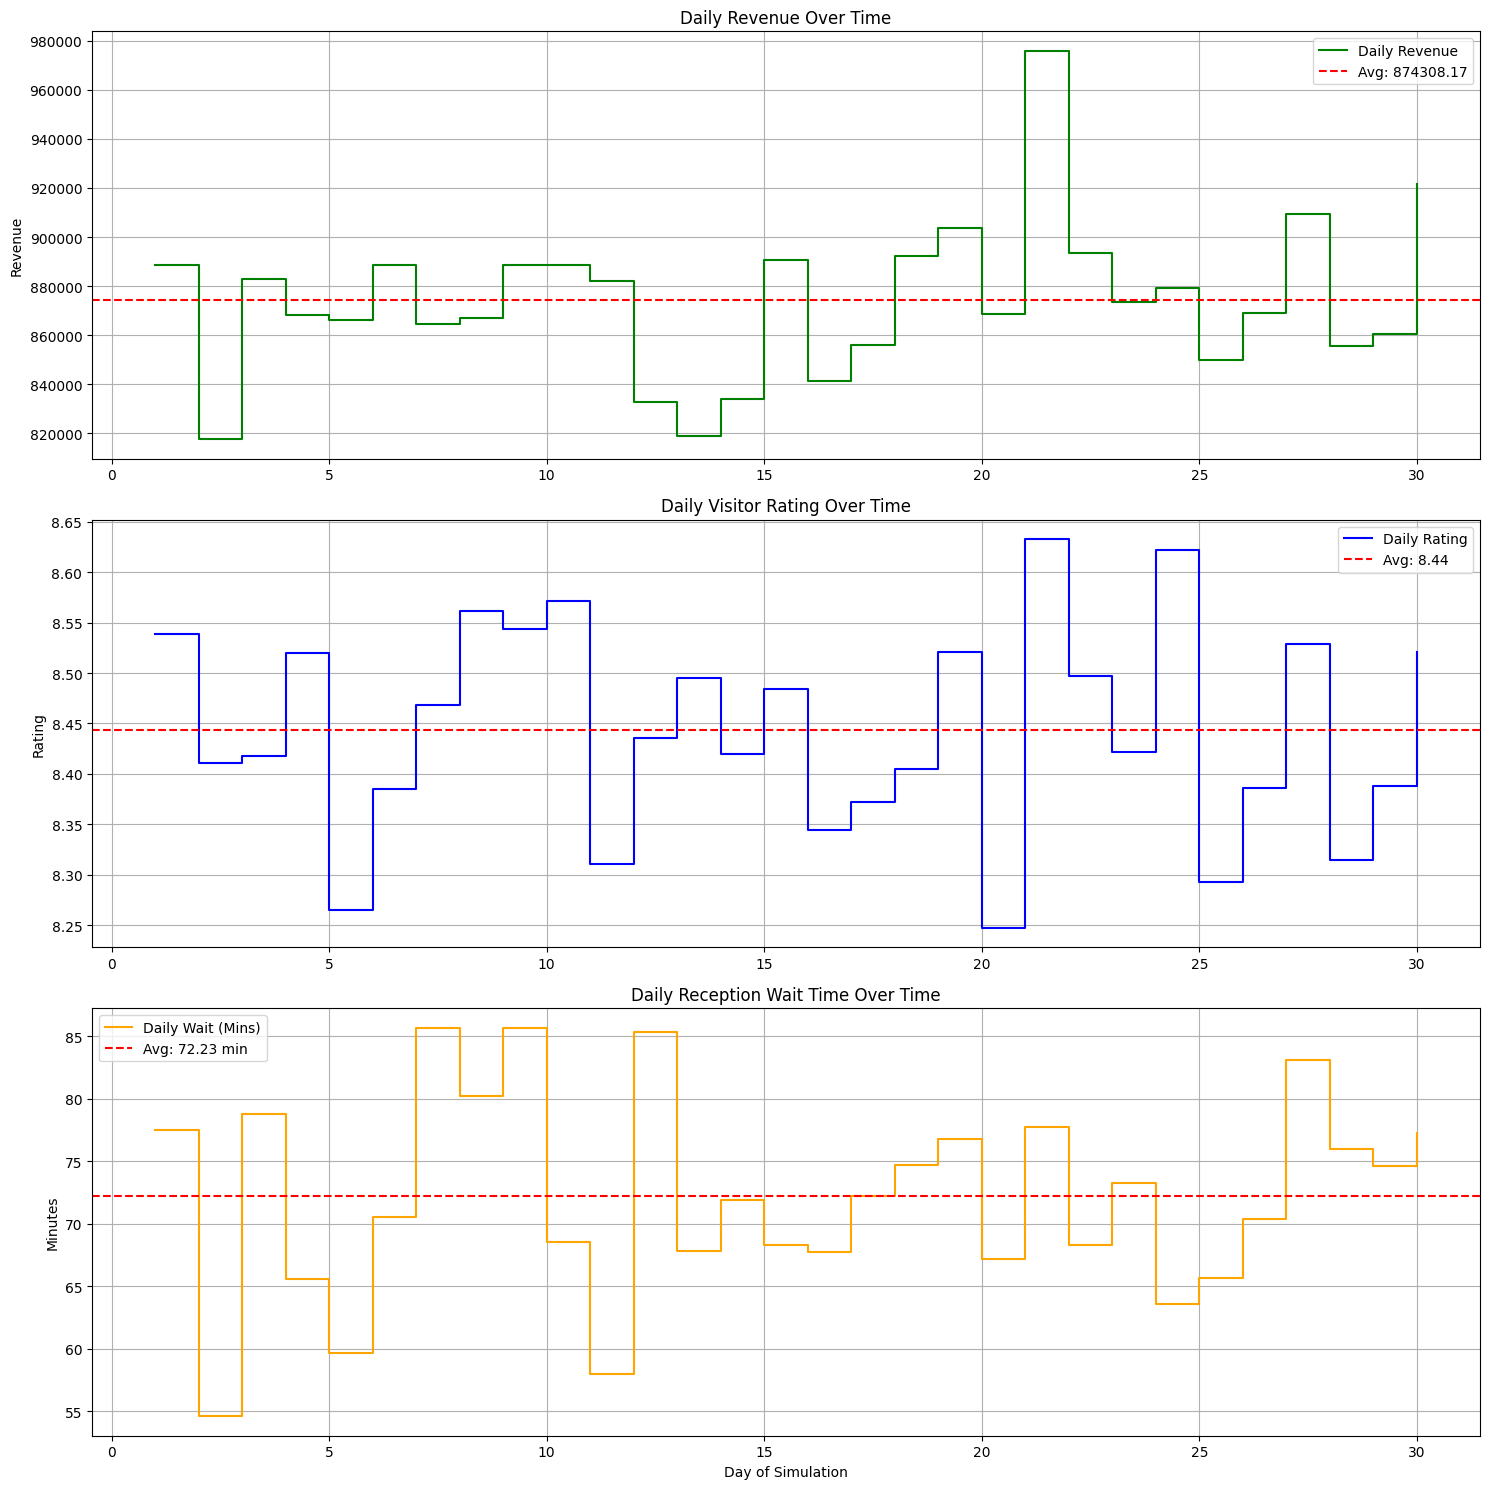

In [19]:
sim.calculate_statistics()
sim.plot_metrics()

# Alternative Review

We will evaluate a configuration consisting of three distinct alternatives:

#### **1. Website Development**
* **Cost:** $100,000
* **Details:** Hiring a skilled development team to build a website that enables online ticket purchases. Consequently, the service time at reception will be reduced to the time required for wristband collection only.
* **Rationale:** We believe that the website will effectively resolve the bottleneck issue at the reception desk.



#### **2. Park Advertising**
* **Cost:** $50,000
* **Details:** Utilizing a professional marketing team to promote the water park, thereby increasing the arrival rate of individuals to 20 per 15-minute interval.
* **Rationale:** We expect that increasing the arrival rate of individuals will lead to higher overall park revenue.



#### **3. Visitor Benefits**
* **Cost:** $50,000
* **Details:** Providing every visitor with a popsicle and a discount voucher for a future visit. This adjustment ensures that every visitor's initial satisfaction rating starts at 11.
* **Rationale:** We anticipate that these visitor benefits will significantly increase the average daily rating.

---

First, we will implement these alternatives in the code:

In [20]:
# Change 1:
def sample_service_time_reception_NEW(self):
      # Including only obtaining the wristband
      return Algorithm.inverse_transform_exp(2)

Reception.sample_service_time = sample_service_time_reception_NEW

# Change 2:
def sample_solo_arrival_interval_NEW():
      return Algorithm.inverse_transform_exp(rate_lambda=(20.0/15.0))

Algorithm.sample_solo_arrival_interval = staticmethod(sample_solo_arrival_interval_NEW)

# Change 3:
# Capture the  original init only if we haven't already
if not hasattr(Visitor, '_true_original_init'):
    Visitor._true_original_init = Visitor.__init__

def new_visitor_init(self, group=None):
    # Run the actual original logic so self.size and other attrs are set
    Visitor._true_original_init(self, group=group)
    # Apply the alternative scenario change
    self.rating = 11

def update_rating_after_facility_SOLO_NEW (self, facility):
        # 50% chance for a good experience
        if Algorithm.uniform_continuous_sampler(0,1) < 0.5:
            A = facility.adrenaline_level
            GS = 1
            self.rating += (0.3*(GS -1))/5 + (0.7*(A-1))/4
            if self.rating > 11:
                self.rating = 11
        else:
          self.rating -= 0.5
          if self.rating < 0:
              self.rating = 0

def update_rating_after_facility_GROUP_NEW (self, facility):
      members_to_rate = []

      if facility.name == "MiniPool":
          # Handle the MiniPool case - only members with age 4 or below has entered the facility, therefore only they will rate it
          for member in self.members:
              if member.age <= 4:
                  members_to_rate.append(member)
      else:
          # This isn't a MiniPool, all members has entered the facility and therefore all of them will rate it
          members_to_rate = self.members

      for member in members_to_rate:
          # 50% chance for a good experience for each group member
          if Algorithm.uniform_continuous_sampler(0,1) <= 0.5:
              A = facility.adrenaline_level
              GS = self.size
              member.rating += (0.3*(GS -1))/5 + (0.7*(A-1))/4
              if member.rating > 11:
                  member.rating = 11
          else:
              member.rating -= 0.5
              if member.rating < 0:
                  member.rating = 0

Visitor.__init__ = new_visitor_init
SoloVisitor.update_rating_after_facility = update_rating_after_facility_SOLO_NEW
Group.update_rating_after_facility = update_rating_after_facility_GROUP_NEW


For the initial $n$, we selected $n=30$. Subsequently, we will check whether we achieve a relative precision of $0.1$ for a significance level of $0.1$ (i.e., $\alpha = 0.1$). Since there are three inequalities we wish to satisfy, according to the Bonferroni inequality, the alpha chosen for each metric will be:

$$\alpha_{adjusted} = \frac{0.1}{3} \approx 0.0333$$

In [21]:
# 1. Run a simulation for 30 days for the alternative scenario
sim_alt = Simulation()
num_runs = 30

for i in range(num_runs):
    designated_seed = i * 2 + 20
    sim_alt.run(designated_seed)

# 2. Extract the daily data into a dictionary
daily_data_alt = {
    'Daily_Revenue': sim_alt.daily_revenues,
    'Daily_Visitor_Rating': sim_alt.daily_avg_ratings,
    'Daily_Wait_Time': [t.total_seconds() / 60 if hasattr(t, 'total_seconds') else t
                        for t in sim_alt.reception.queue.daily_avg_waiting_times[1:]]
}

# 3. Create the DataFrame for the alternative
df_results_alt = pd.DataFrame(daily_data_alt)
df_results_alt.index = range(1, len(df_results_alt) + 1)

# 4. Calculate mean and standard deviation
average_values_alt = df_results_alt.mean()
std_values_alt = df_results_alt.std()

# 5. Add mean and std rows
df_results_alt.loc['Average'] = average_values_alt
df_results_alt.loc['Standard Deviation'] = std_values_alt

# 6. Store values
avg_rev_mean_alt = average_values_alt['Daily_Revenue']
avg_rev_std_alt = std_values_alt['Daily_Revenue']

avg_rating_mean_alt = average_values_alt['Daily_Visitor_Rating']
avg_rating_std_alt = std_values_alt['Daily_Visitor_Rating']

avg_wait_mean_alt = average_values_alt['Daily_Wait_Time']
avg_wait_std_alt = std_values_alt['Daily_Wait_Time']

print("--- Alternative Scenario Results (30 Runs) ---")
print(df_results_alt.round(2))

--- Alternative Scenario Results (30 Runs) ---
                    Daily_Revenue  Daily_Visitor_Rating  Daily_Wait_Time
1                       947245.00                  8.86             0.33
2                       984045.00                  8.90             0.31
3                      1043275.00                  8.88             0.28
4                      1044385.00                  8.97             0.29
5                      1052175.00                  8.80             0.41
6                       991505.00                  8.82             0.24
7                      1015210.00                  8.55             0.35
8                      1017370.00                  8.80             0.22
9                      1021240.00                  8.82             0.33
10                     1015275.00                  8.92             0.40
11                      995785.00                  8.75             0.49
12                     1023215.00                  8.89             0.38
13  

In [22]:
# Defining the Bonferroni corrected alpha
alpha_total = 0.1
num_metrics = 3
alpha_bonferroni = alpha_total / num_metrics # 0.0333

def confidence_interval(mean, std_dev, n, alpha):
    confidence = 1 - alpha
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return lower_bound, upper_bound

# 1. Confidence interval for Daily Revenue (Alternative)
# Changed n from 25 to 30
lower_rev_alt, upper_rev_alt = confidence_interval(avg_rev_mean_alt,
                                                   avg_rev_std_alt,
                                                   30, alpha_bonferroni)
print(f"Confidence Interval for Daily Revenue (Alt): [{lower_rev_alt:.2f}, {upper_rev_alt:.2f}]")

# 2. Confidence interval for Visitor Rating (Alternative)
# Changed n from 25 to 30
lower_rating_alt, upper_rating_alt = confidence_interval(avg_rating_mean_alt,
                                                         avg_rating_std_alt,
                                                         30, alpha_bonferroni)
print(f"Confidence Interval for Daily Visitor Rating (Alt): [{lower_rating_alt:.4f}, {upper_rating_alt:.4f}]")

# 3. Confidence interval for Reception Wait Time (Alternative)
# Changed n from 25 to 30
lower_wait_alt, upper_wait_alt = confidence_interval(avg_wait_mean_alt,
                                                     avg_wait_std_alt,
                                                     30, alpha_bonferroni)
print(f"Confidence Interval for Daily Reception Wait (mins) (Alt): [{lower_wait_alt:.2f}, {upper_wait_alt:.2f}]")

Confidence Interval for Daily Revenue (Alt): [988206.07, 1014291.93]
Confidence Interval for Daily Visitor Rating (Alt): [8.8146, 8.8927]
Confidence Interval for Daily Reception Wait (mins) (Alt): [0.31, 0.36]


In [23]:
# Simulation settings
gamma = 0.1
alpha_total = 0.1
num_metrics = 3
alpha_bonferroni = alpha_total / num_metrics  # Corrected alpha: 0.0333
n = 30

# Metric names for display
metrics = ["Daily Revenue", "Daily Visitor Rating", "Daily Reception Wait (mins)"]

# Extracting means and stds from the alternative summary variables
means_alt = [
    avg_rev_mean_alt,
    avg_rating_mean_alt,
    avg_wait_mean_alt
]

stds_alt = [
    avg_rev_std_alt,
    avg_rating_std_alt,
    avg_wait_std_alt
]

accuracy_results_alt = []
for metric, mean, std in zip(metrics, means_alt, stds_alt):
    relative_error, threshold, meets_criterion = relative_accuracy(mean, std, gamma, alpha_bonferroni, n)
    accuracy_results_alt.append([metric, relative_error, threshold, meets_criterion])

# Creating the summary table for the alternative
df_accuracy_alt = pd.DataFrame(accuracy_results_alt, columns=["Metric", "Relative Error", "Threshold γ/(1+γ)", "Meets Criterion"])

# Printing with rounding for better readability
print("--- Alternative Scenario Relative Accuracy ---")
print(df_accuracy_alt.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

--- Alternative Scenario Relative Accuracy ---
                     Metric  Relative Error  Threshold γ/(1+γ)  Meets Criterion
              Daily Revenue          0.0130             0.0909             True
       Daily Visitor Rating          0.0044             0.0909             True
Daily Reception Wait (mins)          0.0762             0.0909             True


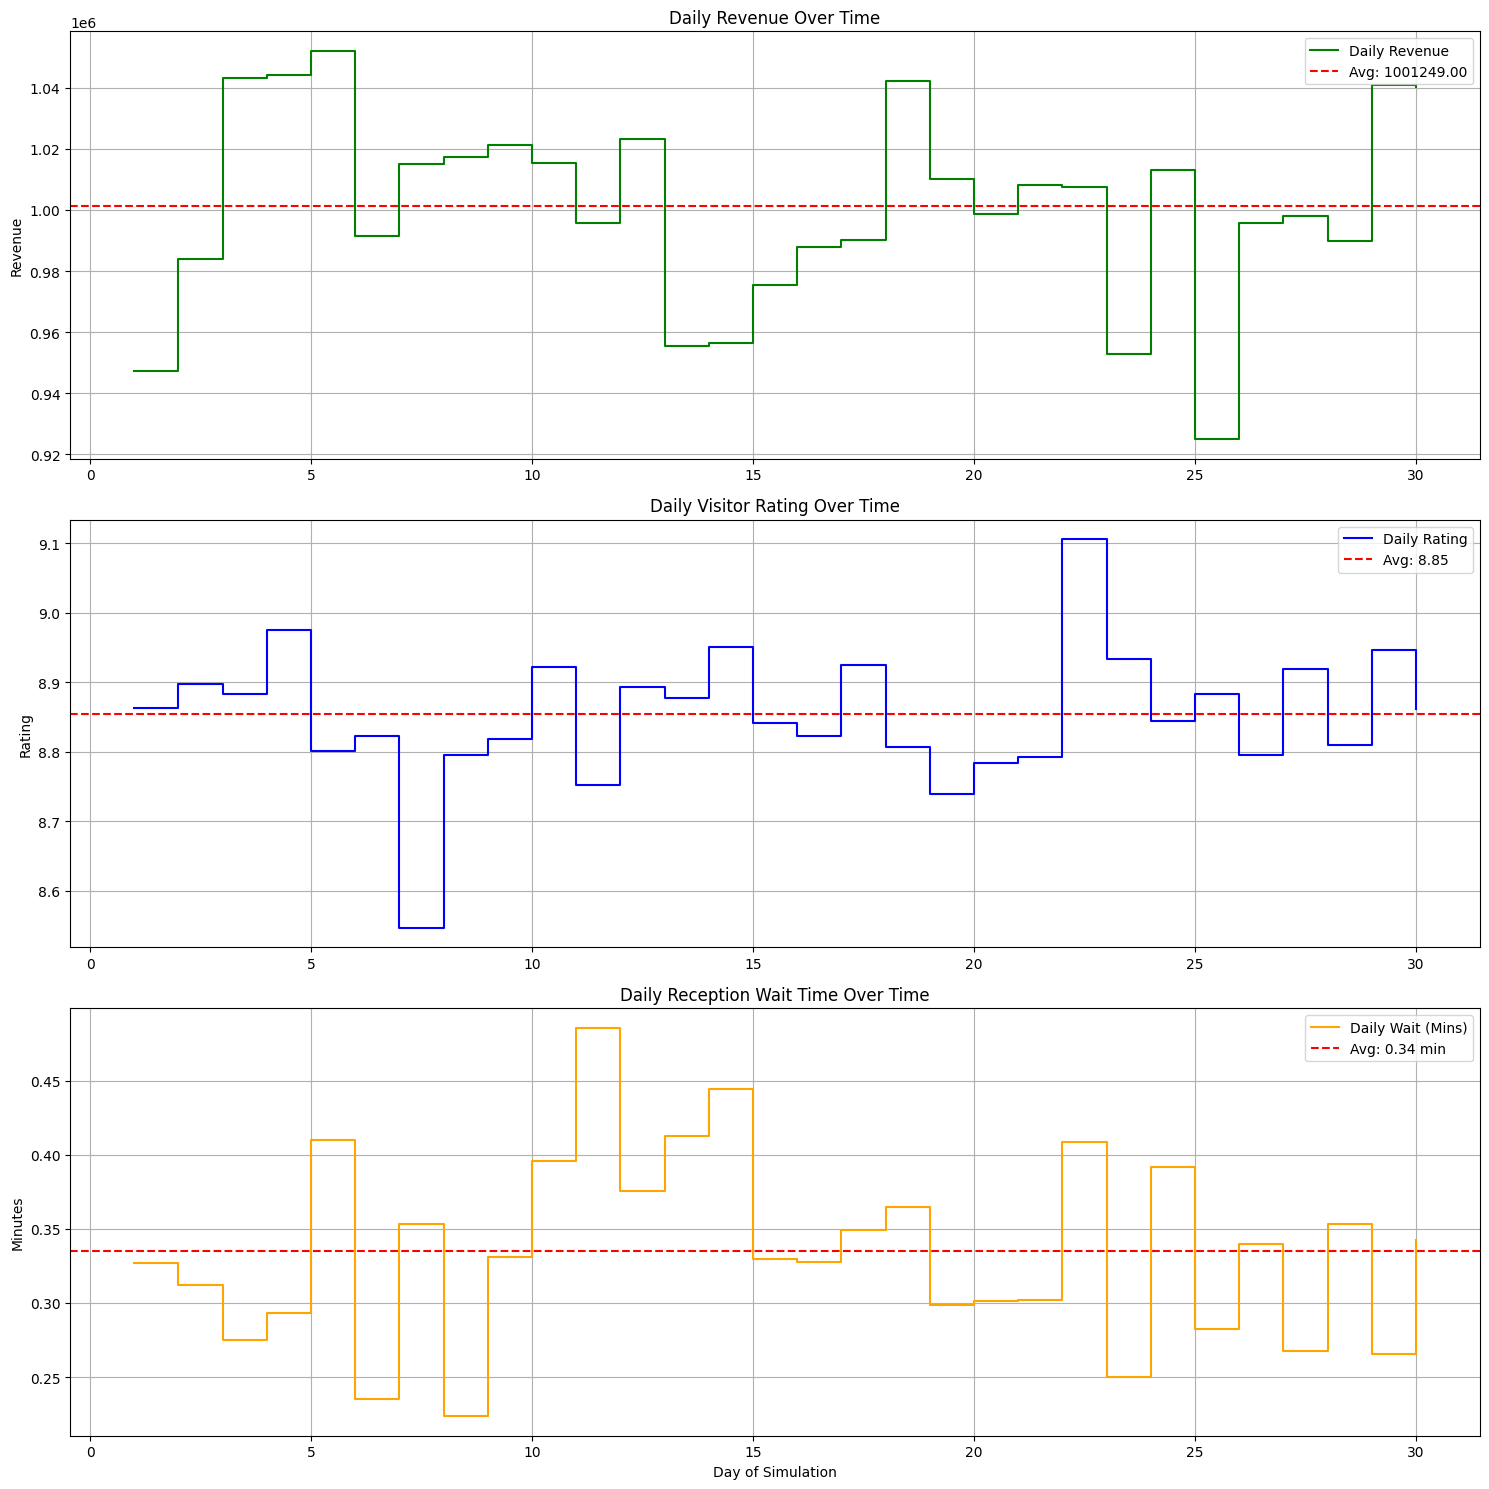

In [24]:
sim_alt.calculate_statistics()
sim_alt.plot_metrics()

# Comparison of Current State to the Alternative State By Paired T-Test

### **Comparison Between Current and Alternative States Using Paired T-Tests**

We will now perform a comparison between the current state and the selected alternative. We chose to use the **Common Random Numbers (CRN)** method. This means we utilized the same random seeds for both simulations; therefore, we will apply a Paired T-Test based on the following assumptions:

* **Correlation Between Parallel Runs:** There is a dependency between day $i$ in the base case and day $i$ in the alternative, resulting from the use of identical seeds. This dependency helps neutralize "background noise" (such as identical guest loads in both scenarios), making the comparison more robust.
* **Independence Within Scenarios:** There is no dependency between the results of different days within the same simulation run.
* **Assumption of Equal Variances:** In accordance with the test requirements, we assume equality of variances between the two alternatives. This assumption is based on the fact that both alternatives operate under the same environmental conditions and random noise sources. Since CRN was used, both systems are exposed to the exact same volatility in guest arrivals and behavior. The changes made were targeted (e.g., quality parameters or service rates), which shifts the location of the results (the mean) but not the nature of their dispersion (the variance).



* **Normality of Differences:** We assume that the **difference** between the metrics on any given day follows a normal distribution. This is justifiable because our metrics are averages, which follow a normal distribution according to the Central Limit Theorem. Statistically, the difference between two normally distributed random variables is also normally distributed.



We aim to compare the current and alternative states across our three chosen metrics at a significance level of $0.1$ (where $\alpha = 0.1$). As before, since we want to satisfy three simultaneous inequalities, we apply the **Bonferroni Inequality**, adjusting the alpha for each individual metric to:

$$\alpha_{adjusted} = \frac{0.1}{3} \approx 0.0333$$

In [25]:
def paired_t_test_ci(data_basic, data_alt, alpha=0.05, metric_name=""):
    # Calculate the differences for each day (Day 1 basic vs Day 1 alt, etc.)
    differences = np.array(data_alt) - np.array(data_basic)
    n = len(differences)

    # Mean and standard deviation of the differences
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)

    # Standard error of the mean difference
    se_diff = std_diff / np.sqrt(n)

    # Critical t-value (n-1 degrees of freedom)
    t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)

    # Confidence interval for the difference
    margin_of_error = t_crit * se_diff
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error

    # Output results
    print(f"--- {metric_name} Comparison (Paired) ---")
    print(f"Mean Difference (Alt - Current): {mean_diff:.4f}")
    print(f"{100*(1-alpha):.0f}% Confidence Interval for the difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

    # Conclusion based on whether 0 is in the interval
    if ci_lower > 0:
        print(f" >>> The Alternative is significantly HIGHER than the Current state.\n")
    elif ci_upper < 0:
        print(f" >>> The Alternative is significantly LOWER than the Current state.\n")
    else:
        print(f" >>> No significant difference found (the interval includes 0).\n")

# ----- Run Comparisons -----

# Updated Alpha for Bonferroni
alpha_total = 0.1
num_comparisons = 3
alpha_adj = alpha_total / num_comparisons  # 0.0333

# 1. Compare Revenue
paired_t_test_ci(
    data_basic=df_results['Daily_Revenue'].iloc[:30],
    data_alt=df_results_alt['Daily_Revenue'].iloc[:30],
    alpha=alpha_adj,
    metric_name="Daily Revenue"
)

# 2. Compare Rating
paired_t_test_ci(
    data_basic=df_results['Daily_Visitor_Rating'].iloc[:30],
    data_alt=df_results_alt['Daily_Visitor_Rating'].iloc[:30],
    alpha=alpha_adj,
    metric_name="Average Rating"
)

# 3. Compare Reception Wait Time
paired_t_test_ci(
    data_basic=df_results['Daily_Wait_Time'].iloc[:30],
    data_alt=df_results_alt['Daily_Wait_Time'].iloc[:30],
    alpha=alpha_adj,
    metric_name="Reception Wait Time"
)

--- Daily Revenue Comparison (Paired) ---
Mean Difference (Alt - Current): 126940.8333
97% Confidence Interval for the difference: [111585.9340, 142295.7326]
 >>> The Alternative is significantly HIGHER than the Current state.

--- Average Rating Comparison (Paired) ---
Mean Difference (Alt - Current): 0.4097
97% Confidence Interval for the difference: [0.3555, 0.4638]
 >>> The Alternative is significantly HIGHER than the Current state.

--- Reception Wait Time Comparison (Paired) ---
Mean Difference (Alt - Current): -71.8989
97% Confidence Interval for the difference: [-75.1535, -68.6442]
 >>> The Alternative is significantly LOWER than the Current state.



# Project Analysis - Conclusions and Recommendations

This project utilizes a Discrete Event Simulation to model the daily operations of a water park, including visitor interaction with various facilities and the monitoring of key performance indicators (KPIs).

In the analysis of the **Current State**, we identified that waiting times at the reception desk constitute a significant system bottleneck. Furthermore, we tracked the Average Daily Revenue and Average Daily Visitor Rating, as we believe these metrics reliably reflect the park's operational performance and business success. Consequently, we evaluated an integrated alternative consisting of three components: Website Development, Park Advertising, and Visitor Benefits (at a total cost of $200,000).

Statistically, the **combination of these three alternatives improved all performance metrics at a 10% significance level**:

* **Reception Wait Time:** Despite a significant increase in visitor volume (due to advertising), the average wait time decreased by approximately **72 minutes**. This proves that the efficiency gained by the website (reducing service time to wristband collection only) outweighs the additional load generated by increased marketing.
* **Visitor Rating:** There was a significant increase of approximately **0.4 points**. This improvement is directly attributed to the Visitor Benefits alternative, which raised the baseline satisfaction level (from an initial rating of 10 to 11).
* **Revenue:** Transitioning to the integrated alternative led to an average daily revenue increase of approximately **$126,940**. This growth stems from the higher arrival rate of individuals (20 visitors per 15 minutes) combined with the website's ability to process guests faster, ensuring more visitors enter the park rather than getting stuck in the reception queue.



---

#### **Conclusion:** Based on the data analysis, the **Alternative State is superior to the Current State at a 10% significance level**.

The total cost of the upgrade is $200,000. Given the significant increase in daily revenue, we expect the **investment to reach its break-even point in less than two business days**.


This strategy represents a perfect synergy: Advertising brings more people in, the website ensures they don't get stuck at the entrance, and the benefits ensure they leave satisfied. Therefore, **our recommendation is to implement all three alternatives as a single package**, as they collectively resolve bottlenecks and maximize the park's economic potential.